## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

План выполнения проекта:

Шаг 1. Загрузка данных и первичный анализ  
Шаг 3. Объединение данных и их предобработка  
Шаг 4. Исследовательский анализ  
Шаг 5. Корреляционный анализ  
Шаг 6. Обучение моделей машинного обучения  
Шаг 8. Выбор лучшей модели  
Шаг 9. Анализ матрицы ошибок  
Шаг 10. Анализ важности признаков  
Шаг 9. Общий вывод и рекомендации заказчику    

**При выполнении проекта использовалась  библиотека sklearn версии 1.6.1**

## Загрузка данных и первичный анализ

In [1]:
!pip install phik -q
!pip install shap -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, 
                                    OneHotEncoder, 
                                    MinMaxScaler,
                                    OrdinalEncoder,
                                    )
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
                             accuracy_score,
                             confusion_matrix,
                             recall_score,
                             precision_score,
                             roc_auc_score,
                             f1_score)
from sklearn.dummy import DummyClassifier
import warnings
import shap
import phik

In [3]:
# Зададим переменные RANDOM_STATE, TEST_SIZE и CURRENT_DATE
RANDOM_STATE = 80925
TEST_SIZE = 0.25
CURRENT_DATE = "2020-02-01"

In [4]:
# Загрузка данных
try:
    df_contract = pd.read_csv("/datasets/contract_new.csv", parse_dates=['BeginDate'])
    df_personal = pd.read_csv("/datasets/personal_new.csv")
    df_internet = pd.read_csv("/datasets/internet_new.csv")
    df_phone = pd.read_csv("/datasets/phone_new.csv")
except:    
    df_contract = pd.read_csv("C:\\Users\\Тимур\\Downloads\\contract_new.csv", parse_dates=['BeginDate'])
    df_personal = pd.read_csv("C:\\Users\\Тимур\\Downloads\\personal_new.csv")
    df_internet = pd.read_csv("C:\\Users\\Тимур\\Downloads\\internet_new.csv")
    df_phone = pd.read_csv("C:\\Users\\Тимур\\Downloads\\phone_new.csv")

In [5]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


**df_contract:**   
- 7043 строки и 8 колонок  
- пропусков нет
- необходимо изменить тип данных в некоторых колонках (TotalCharges)
- необходимо привести названия колонок к одному стилю

In [7]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**df_personal:**   
- 7043 строки и 5 колонок  
- пропусков нет
- необходимо привести навзания колонок к одному стилю

In [9]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**df_internet:**   
- 5517 строки и 8 колонок  
- пропусков нет
- необходимо привести навзания колонок к одному стилю

In [11]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [12]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**df_phone:**   
- 6361 строки и 2 колонок  
- пропусков нет
- необходимо привести навзания колонок к одному стилю

## Объединение данных и  их предобработка

In [13]:
# Объединим датафреймы
df_merged = pd.merge(df_contract, df_personal, how = 'left', on = 'customerID'). \
                             merge(df_internet, how = 'left', on = 'customerID'). \
                             merge(df_phone, how = 'left', on = 'customerID')

In [14]:
# Проверим размерность
df_merged.shape

(7043, 20)

In [15]:
# Выведем первые строки
df_merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [16]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Изменим тип данных в колонке TotalCharges на int:

In [17]:
# Меняем тип данных на числовой и выводим количество пропусков
df_merged['TotalCharges'] = pd.to_numeric(df_merged['TotalCharges'], errors='coerce')
df_merged['TotalCharges'].isna().sum()

np.int64(11)

Количество неопределенных значений равно 11. Выведем эти строки:

In [18]:
# Неопределенные значения в 'TotalCharges'
df_merged.loc[df_merged['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Видим, что значение 'TotalCharges' не определено для клиентов, начало договора у которых датируется 1 февраля 2020. Заменим данные пропуски на 0:

In [19]:
df_merged['TotalCharges'] = df_merged['TotalCharges'].fillna(0)
df_merged['TotalCharges'].isna().sum()

np.int64(0)

Приведем названия колонок к змеиному типу:

In [20]:
# Приведем названия колонок к змеиному стилю
df_merged.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df_merged.columns]
df_merged.rename(columns={
                          'customer_i_d':'customer_id',
                          'streaming_t_v':'streaming_tv'
                         }, inplace=True)

In [21]:
df_merged.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Проверим значения в колонках с категориальными признаками:

In [22]:
# выведем уникальные значения в колонках с категориальными признаками в df_merged
for column in df_merged.columns:
    if column not in ['begin_date', 'end_date', 'duration_days', 
                      'current_date', 'monthly_charges', 'total_charges', 'customer_id']:
        print(f'Значения в колонке {column}:', df_merged[column].unique())

Значения в колонке type: ['Month-to-month' 'One year' 'Two year']
Значения в колонке paperless_billing: ['Yes' 'No']
Значения в колонке payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Значения в колонке gender: ['Female' 'Male']
Значения в колонке senior_citizen: [0 1]
Значения в колонке partner: ['Yes' 'No']
Значения в колонке dependents: ['No' 'Yes']
Значения в колонке internet_service: ['DSL' 'Fiber optic' nan]
Значения в колонке online_security: ['No' 'Yes' nan]
Значения в колонке online_backup: ['Yes' 'No' nan]
Значения в колонке device_protection: ['No' 'Yes' nan]
Значения в колонке tech_support: ['No' 'Yes' nan]
Значения в колонке streaming_tv: ['No' 'Yes' nan]
Значения в колонке streaming_movies: ['No' 'Yes' nan]
Значения в колонке multiple_lines: [nan 'No' 'Yes']


In [23]:
# Отдельно проверим колонку 'customer_id'
print('Значения в колонке customer_id:', sorted(df_merged['customer_id'].unique()))

Значения в колонке customer_id: ['0002-ORFBO', '0003-MKNFE', '0004-TLHLJ', '0011-IGKFF', '0013-EXCHZ', '0013-MHZWF', '0013-SMEOE', '0014-BMAQU', '0015-UOCOJ', '0016-QLJIS', '0017-DINOC', '0017-IUDMW', '0018-NYROU', '0019-EFAEP', '0019-GFNTW', '0020-INWCK', '0020-JDNXP', '0021-IKXGC', '0022-TCJCI', '0023-HGHWL', '0023-UYUPN', '0023-XUOPT', '0027-KWYKW', '0030-FNXPP', '0031-PVLZI', '0032-PGELS', '0036-IHMOT', '0040-HALCW', '0042-JVWOJ', '0042-RLHYP', '0048-LUMLS', '0048-PIHNL', '0052-DCKON', '0052-YNYOT', '0056-EPFBG', '0057-QBUQH', '0058-EVZWM', '0060-FUALY', '0064-SUDOG', '0064-YIJGF', '0067-DKWBL', '0068-FIGTF', '0071-NDAFP', '0074-HDKDG', '0076-LVEPS', '0078-XZMHT', '0080-EMYVY', '0080-OROZO', '0082-LDZUE', '0082-OQIQY', '0083-PIVIK', '0089-IIQKO', '0093-EXYQL', '0093-XWZFY', '0094-OIFMO', '0096-BXERS', '0096-FCPUF', '0098-BOWSO', '0100-DUVFC', '0103-CSITQ', '0104-PPXDV', '0106-GHRQR', '0106-UGRDO', '0107-WESLM', '0107-YHINA', '0111-KLBQG', '0112-QAWRZ', '0112-QWPNC', '0114-IGABW', '

Опечаток и некорректных значений не обнаружено.

Выведем количество пропусков в колонках:

In [24]:
# Количесвто пропущенных значений в столбцах
df_merged.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Пропуски возникли после объединения таблиц для клиентов, у которых не подключен либо интернет, либо телефония. Перед заполнением пропусков создадим две колонки - 'internet' и 'phone', которые будут содержать в себе индикатор, подключена соответствующая услуга или нет.

In [25]:
# Создаем колонки 'internet' и 'phone'
df_merged['internet'] = df_merged.apply(lambda row: 'No' if pd.isna(row['online_security']) else 'Yes', axis=1)
df_merged['phone'] = df_merged.apply(lambda row: 'No' if pd.isna(row['multiple_lines']) else 'Yes', axis=1)    

In [26]:
# Выведем первые строки
df_merged.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet,phone
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,Yes,Yes
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,Yes,Yes
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,NaN,Yes,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,Yes,Yes


In [27]:
# Заполним пропуски на 'No'
df_merged = df_merged.fillna('No')

In [28]:
# Снова проверим данные на пропущенные значения
df_merged.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
internet             0
phone                0
dtype: int64

Таким образом, с помощью создания дополнительных колонок мы разделили два сценария: когда дополнительная услуга не подключена и когда не подключен интернет либо телефония.

Проверим данные на дубликаты:

In [29]:
# Проверка на наличие полных дубликатов
df_merged.duplicated().sum()

np.int64(0)

In [30]:
# Проверка на наличие дубликатов в колонке 'customer_id'
df_merged['customer_id'].duplicated().sum()

np.int64(0)

Сделаем колонку 'customer_id' индексом:

In [31]:
# Сделаем 'customer_id' индексом
df_merged = df_merged.set_index('customer_id')

In [32]:
df_merged.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet,phone
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,No,Yes,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,Yes,Yes
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,Yes,Yes
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,No,Yes,No
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,Yes,Yes


Добавим колонку 'current_date'с текущей датой:

In [33]:
# Колонка с текущей датой
df_merged['current_date'] = CURRENT_DATE
df_merged['current_date'] = pd.to_datetime(df_merged['current_date'], format='%Y-%m-%d')

In [34]:
df_merged.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet,phone,current_date
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,Yes,No,No,No,No,No,Yes,No,2020-02-01
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,Yes,No,Yes,No,No,No,No,Yes,Yes,2020-02-01
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,Yes,Yes,No,No,No,No,No,Yes,Yes,2020-02-01
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,Yes,No,Yes,Yes,No,No,No,Yes,No,2020-02-01
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,No,No,Yes,Yes,2020-02-01


Посчитаем длительность действия договора и сохраним его в коллонку 'duration_days':

In [35]:
# Считаем длительность дейстивя договора
df_merged['duration_days'] = (df_merged.apply(lambda row: (pd.to_datetime(row['end_date'], format='%Y-%m-%d') 
                                                                 -row['begin_date']) if row['end_date']!='No' 
                                                 else row['current_date']-row['begin_date'], axis=1)).dt.days

In [36]:
df_merged.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet,phone,current_date,duration_days
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,Yes,No,No,No,No,No,Yes,No,2020-02-01,31
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,No,Yes,No,No,No,No,Yes,Yes,2020-02-01,1036
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,Yes,No,No,No,No,No,Yes,Yes,2020-02-01,123
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,No,Yes,Yes,No,No,No,Yes,No,2020-02-01,1371
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,No,Yes,Yes,2020-02-01,153


In [37]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   object        
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

Создадим целевой признак 'contract_terminated', содержащий в себе индикатор расторжения договора:

In [38]:
# Создадим целевой признак 'contract_terminated'
df_merged['contract_terminated'] = df_merged.apply(lambda row: 0 if row['end_date']=='No' else 1, axis=1)

In [39]:
# Выведем первые строки датафрейма
df_merged.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet,phone,current_date,duration_days,contract_terminated
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,No,No,No,No,No,Yes,No,2020-02-01,31,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,Yes,No,No,No,No,Yes,Yes,2020-02-01,1036,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,No,No,No,No,No,Yes,Yes,2020-02-01,123,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,Yes,Yes,No,No,No,Yes,No,2020-02-01,1371,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,Yes,Yes,2020-02-01,153,0


**На данном этапе было выполнено:**  
    - объединение датафреймов  
    - обработка неопределенных значений в колонках, возникших после объединения  
    - создание дополнительных колонок 'internet' и 'phone' с индикаторами подключения соответствующей услуги  
    - приведение названия колонок к змеиному стилю  
    - изменение типа данных в колонках  
    - проверка данных на дубликаты  
    - проверка категориальных колонок на опечатки и некорректные значения  
    - преобразование колонки 'customer_id' в индекс  
    - создание дополнительных колонок 'duration_days' с длительностью действия договора и 'contract_terminated' с индикатором, расторгнут договор или нет  
    

## Исследовательский анализ данных

Выведем общую статистику колонок с числовыми признаками:

In [40]:
#Выведем общую статистику
df_merged[['monthly_charges', 'senior_citizen', 'contract_terminated', 'total_charges']].describe().T

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
senior_citizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00
contract_terminated,7043.0,0.156325,0.363189,0.00,0.00,0.00,0.00,1.00
total_charges,7043.0,2115.312885,2112.742814,0.00,436.75,1343.35,3236.69,9221.38


- средняя величина расходов за месяц клиентов - 65, диапазон значений - 18.25 - 118.75  
- средняя величина общих расходов клиентов - 2115, диапазон значений - 0 - 9221  
- доля пенсионеров среди клиентов - 16 %  
- доля клиентов, расторгнувших договор - 15.6 % (что говорит о дисбалансе классов в целевом признаке)  

Выведем статистику значений в колонке 'duration_days для клиентов, которые расторгли договор:

In [41]:
(df_merged.loc[df_merged['contract_terminated']==1]['duration_days']).describe()

count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: duration_days, dtype: float64

- среднее значение длительности действия договора - 925 дней, диапазон значений - 28 - 2129 дней

Выведем статистику значений в колонке 'duration_days для клиентов, которые НЕ расторгли договор на данный момент:

In [42]:
(df_merged.loc[df_merged['contract_terminated']==0]['duration_days']).describe()

count    5942.000000
mean      893.681084
std       716.958551
min         0.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: duration_days, dtype: float64

- среднее значение длительности действия договора - 893 дня, диапазон значений - 0 - 2314 дней

Построим гистограммы и боксплоты для 'monthly_charges', 'total_charges':

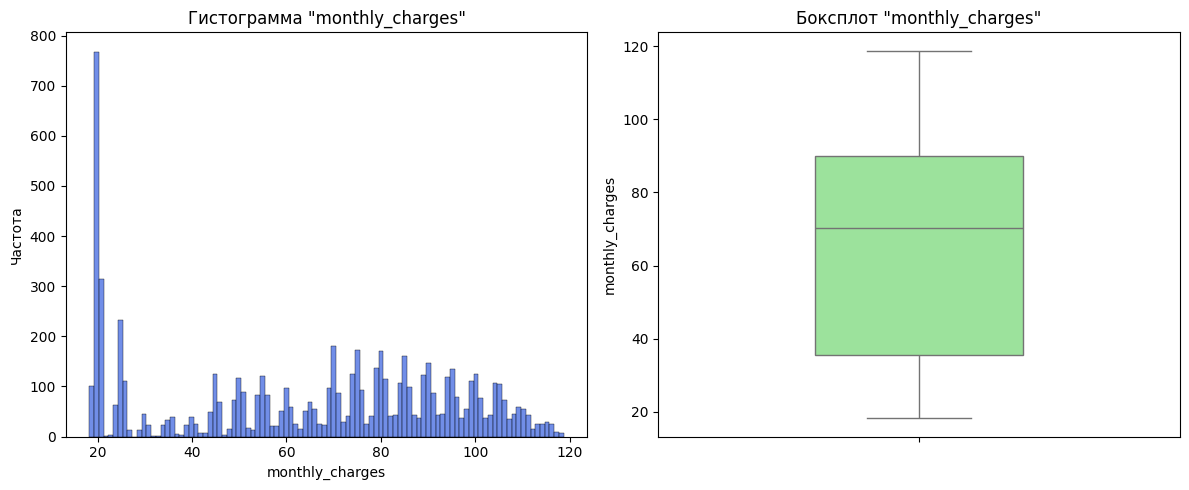

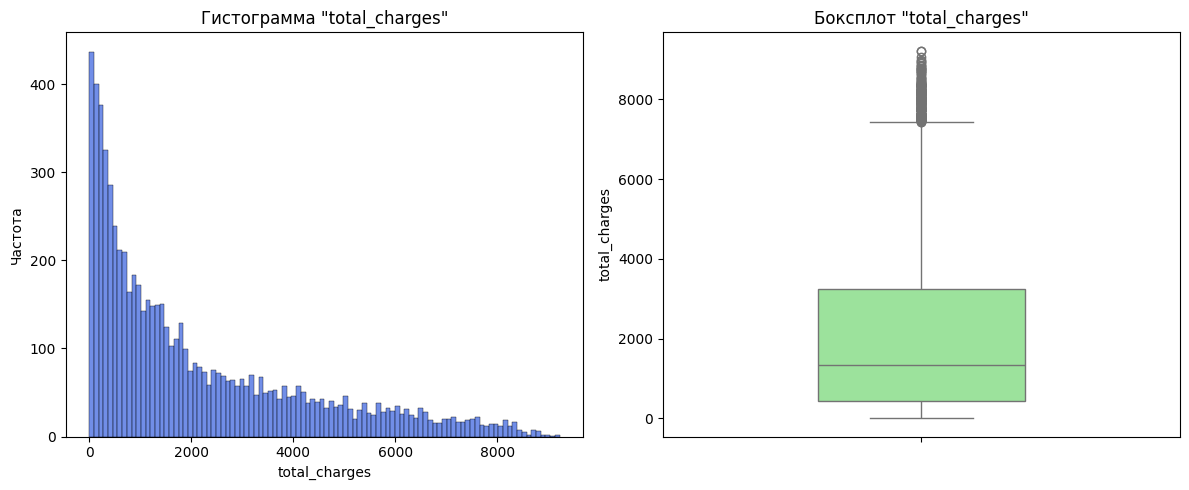

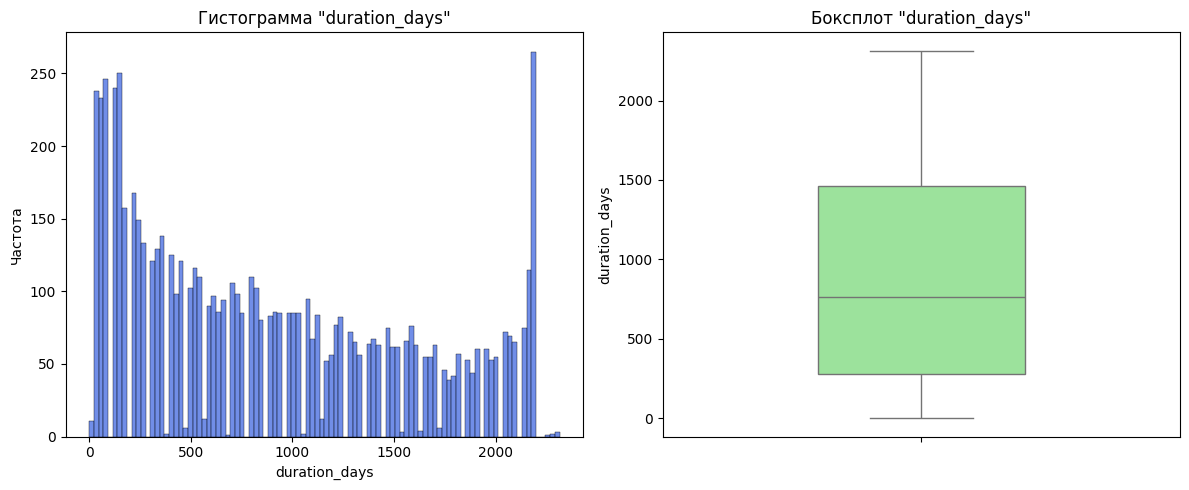

In [43]:
# выведем гистограммы и боксплоты 
col_for_hist = ['monthly_charges', 'total_charges', 'duration_days']
for column in col_for_hist:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    #Гистограмма 
    sns.histplot(
        data=df_merged,
        x=column,
        bins=100,          
        ax=axes[0],       
        color='royalblue'
    )
    axes[0].set_title(f'Гистограмма "{column}"')
    axes[0].set_xlabel(f'{column}')
    axes[0].set_ylabel('Частота')

    #Боксплот
    sns.boxplot(
    data=df_merged,
    y=column,
    ax=axes[1],
    color='lightgreen',
    width=0.4
    )

    axes[1].set_title(f'Боксплот "{column}"')
    axes[1].set_ylabel(f'{column}')
    axes[1].set_xlabel('')

    plt.tight_layout()
    plt.show()

- на гистограмме "monthly_charges" наблюдается пик на значених ~18-20 
- гистограмма "total_charges" напоминает график функции вероятности распределения Пуассона, максимум располагается на низких значениях и уменьшается по мере увеличения значения "total_charges"
- на гистограмме 'duration_days' наблюдается два максимума - на значениях ниже 250 и выше 2000  

Выведем столбчатые диаграммы для категориальных признаков:

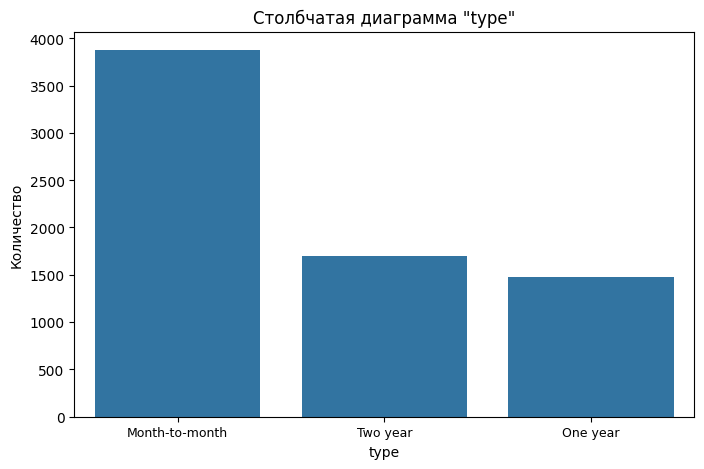

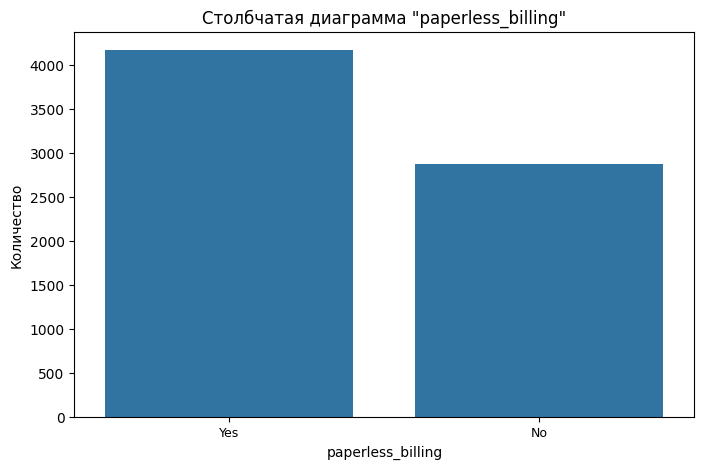

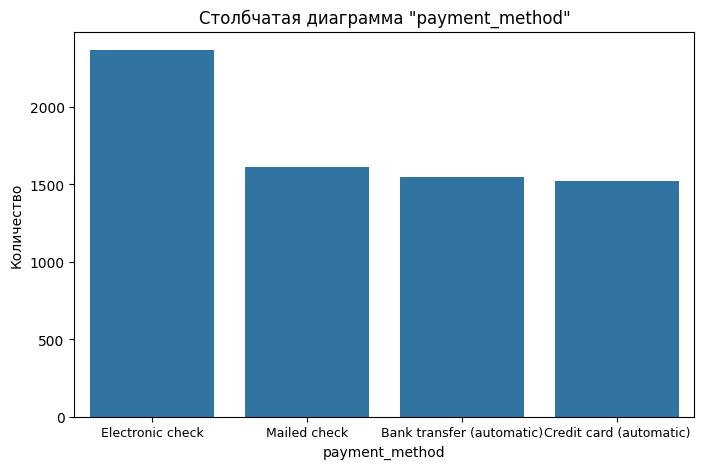

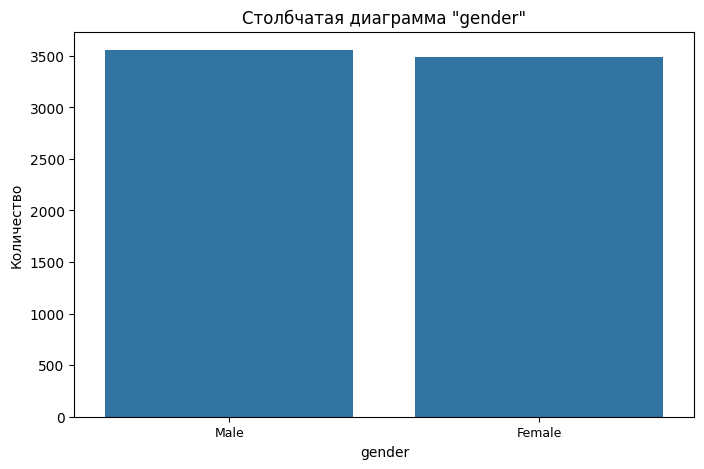

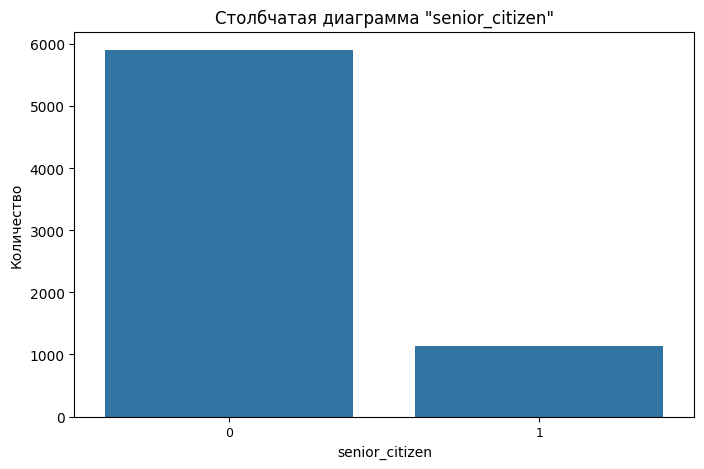

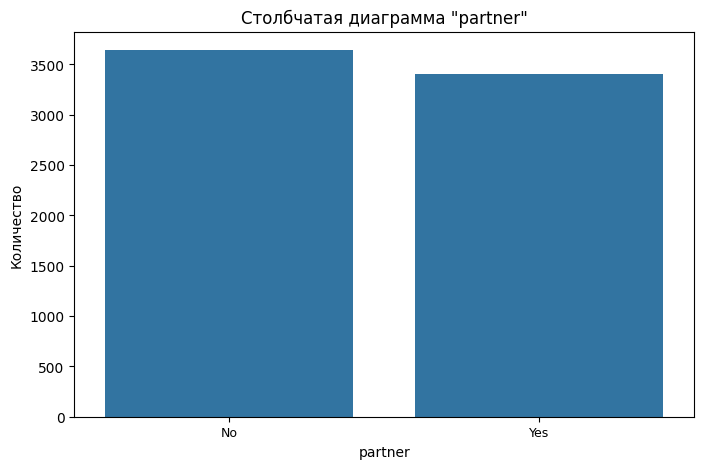

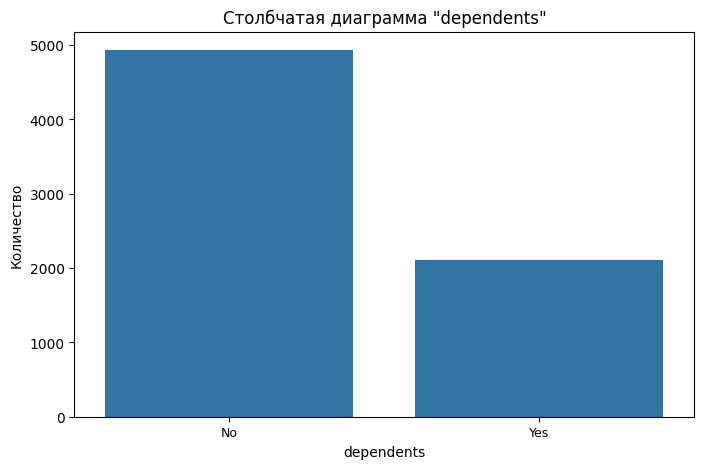

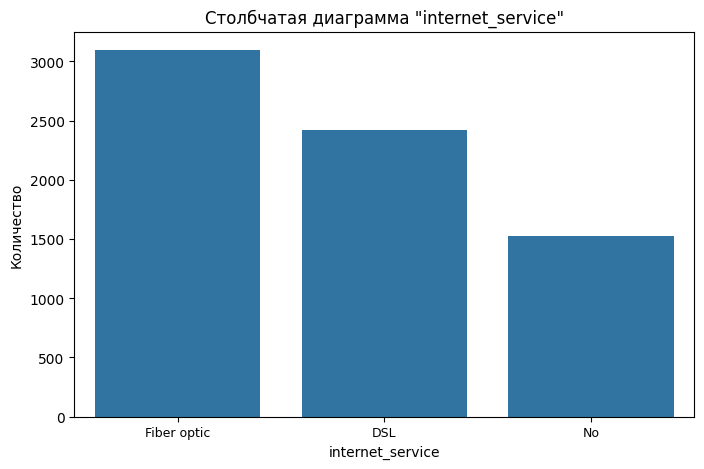

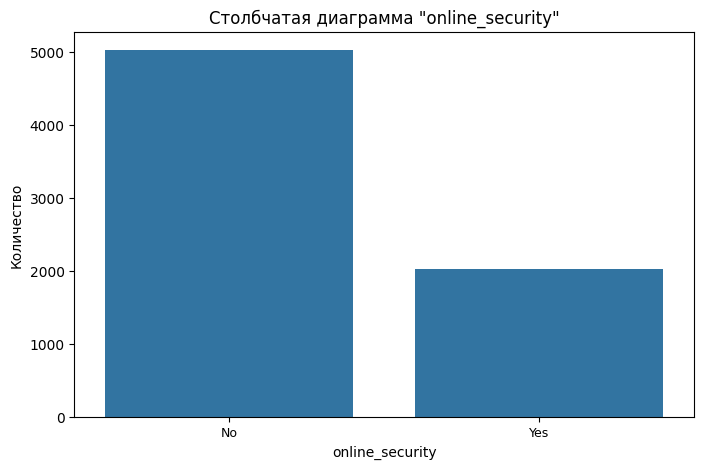

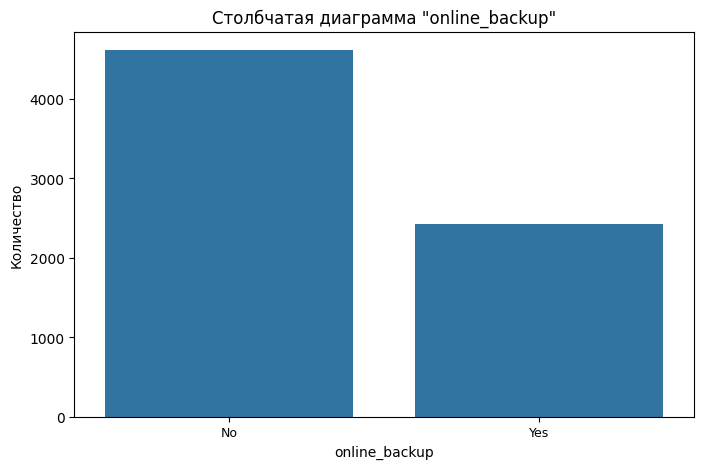

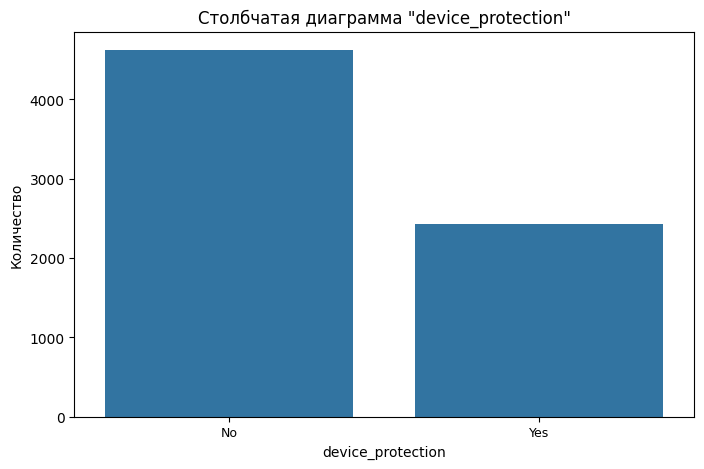

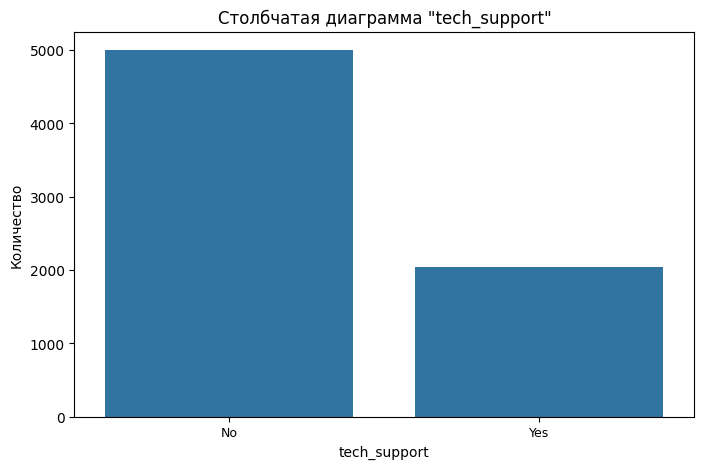

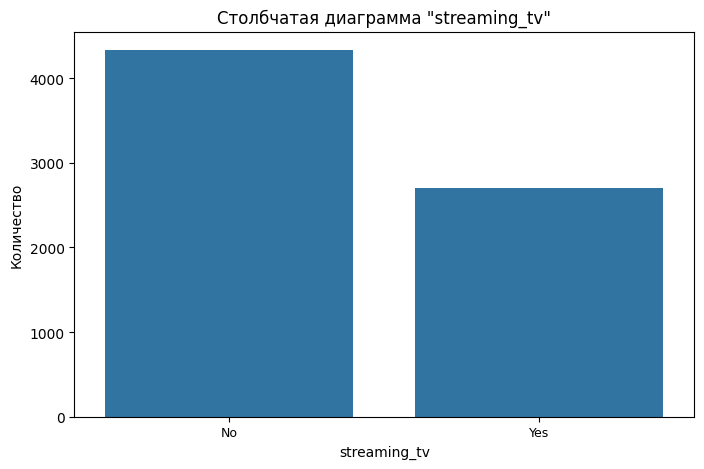

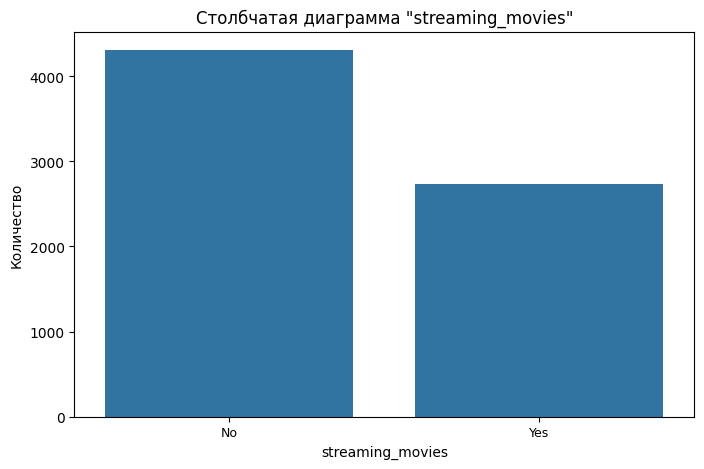

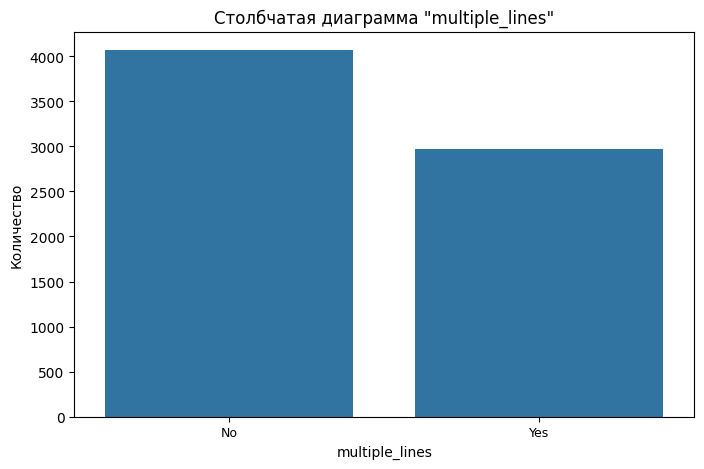

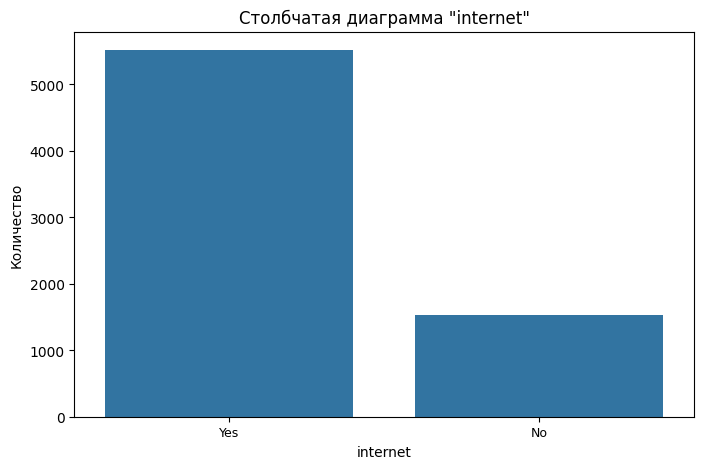

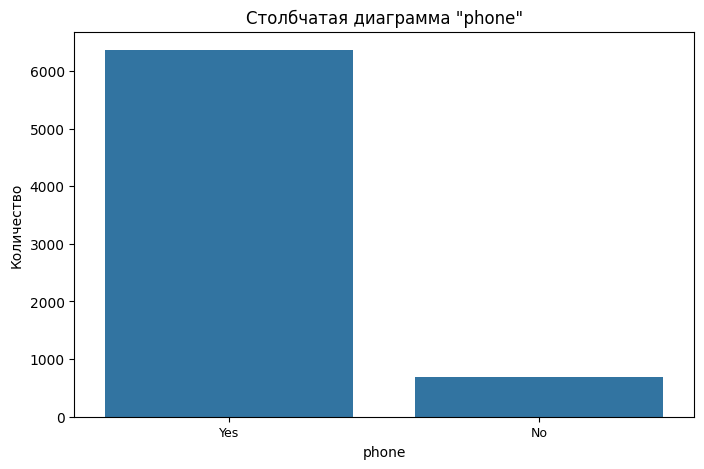

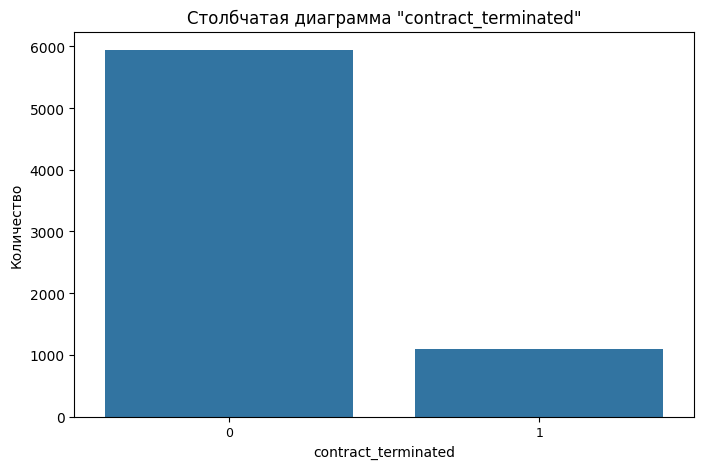

In [44]:
# Создадим список необходимых категориальных признаков для построения графиков:
cat_columns = []
for column in df_merged.columns:
    if column not in ['begin_date', 'end_date', 'duration_days', 'current_date', 'monthly_charges', 'total_charges']:
        cat_columns.append(column)
        
# Построение столбчатых диаграмм        
for column in cat_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(
    data=df_merged,
    x=column,
    order=df_merged[column].value_counts().index
    )
    plt.title(f'Столбчатая диаграмма "{column}"')
    plt.xlabel(f'{column}')
    plt.ylabel('Количество')
    plt.xticks(fontsize=9)
    plt.show()

- преоладает ежемесячная оплата (около 4000 клиентов), оплата "раз в год" и "раз в два года" - примерно поровну (по ~1500 клиентов)  
- преобладают клиенты, использующие элеткронный расчетный счет (более 4000 клиентов)  
- преобладает тип платежа "Electronic check" (около 2500 клиентов), остальные типы платежа - примерно поровну (по 1500 клиентов)  
- женщин и мужчин среди клиентов одинаковое количество  
- пенсионеров - чуть более 1000 клиентов (16 % как было показано ранее)  
- клиентов в браке и не в браке - примерно одинаковое количество  
- преобладают клиенты без детей (около 5000)  

Cреди клиентов, пользующихся интернетом:

- более 3000 пользуются fiber optic, чуть менее 2500 - DSL  
- около 3500 клиентов не пользутся услугой "online_security", около 2000 клиентов пользуются  
- около 3100 клиентов не пользуются услугой "online_backup", около 2500  - пользуются  
- около 3100 клиентов не пользуются услугой "device rotection", около 2500  - пользуются  
- около 3500 клиентов не пользуются услугой "tech_support", около 2000  - пользуются   
- количество клиентов, пользующихся услугами "streaming_tv" и "streaming_movies", примерно равное количество  

- среди клиентов, пользующихся услугами телефонии, около 3400 не пользуются услугой "multiple_lines", примерно 3000 клиентов - пользуются  
- около 6000 клиентов не расторгли договор, примерно 1000 - расторгли (наблюдается дисбаланс целевого признака)  

Создадим дополнительных колонки: с годами и месяцами заключения и расторжения договоров и построим по ним столбчатые диаграммы:

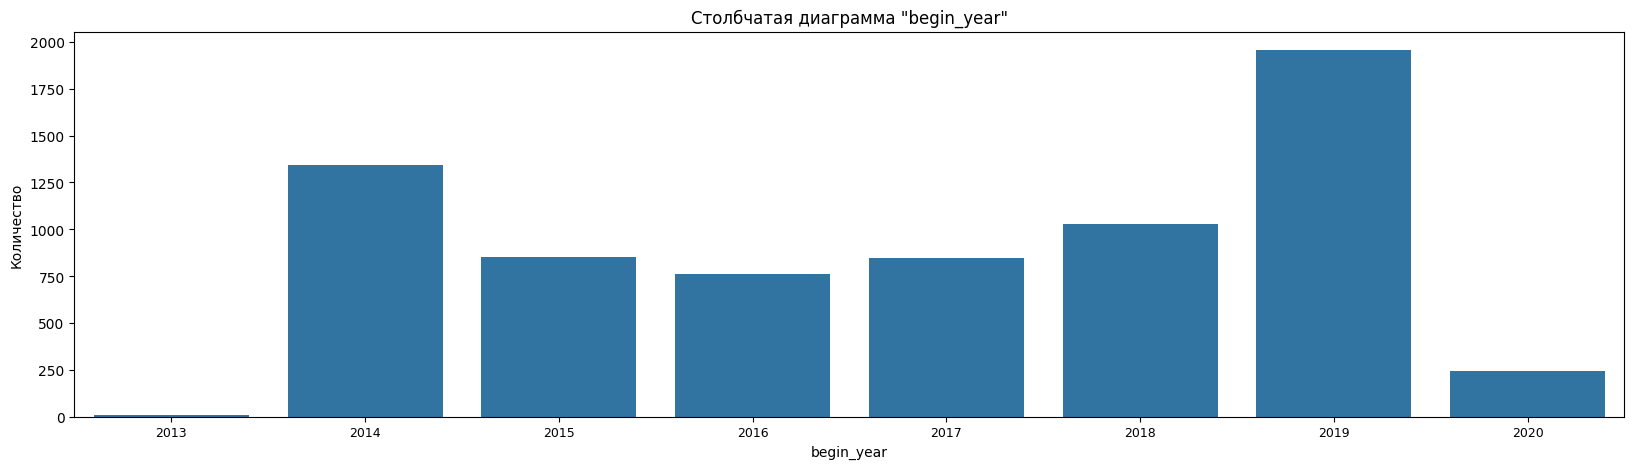

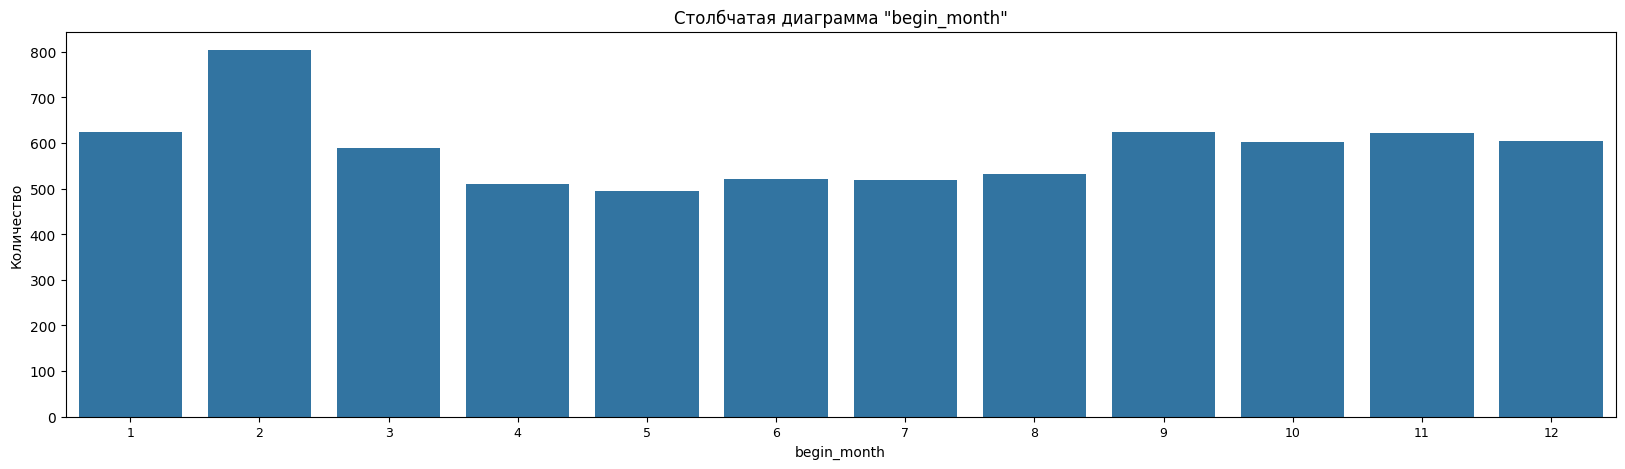

In [45]:
# Создадим дополнительные колонки - с годом и месяцем закключения договора на услуги связи и 
# построим столбчаты диаграммы
df_merged['begin_year'] = df_merged['begin_date'].dt.year
df_merged['begin_month'] = df_merged['begin_date'].dt.month
for column in ['begin_year', 'begin_month']:
    plt.figure(figsize=(20, 5))
    sns.countplot(
    data=df_merged,
    x=column,
    )
    plt.title(f'Столбчатая диаграмма "{column}"')
    plt.xlabel(f'{column}')
    plt.ylabel('Количество')
    plt.xticks(fontsize=9)
    plt.show()

- наибольшее количество договор на услуги связи заключено в 2019 году (около 2000), далее по убыванию 2014 год (окодо 1400 договоров)  
- наибольшее количество договоров приходитсчя на февраль (около 800), менее всего наблюдается в весенне-летний сезон (около 500 в месяц), в остальные месяцы примерно одинаково - по 600 договоров

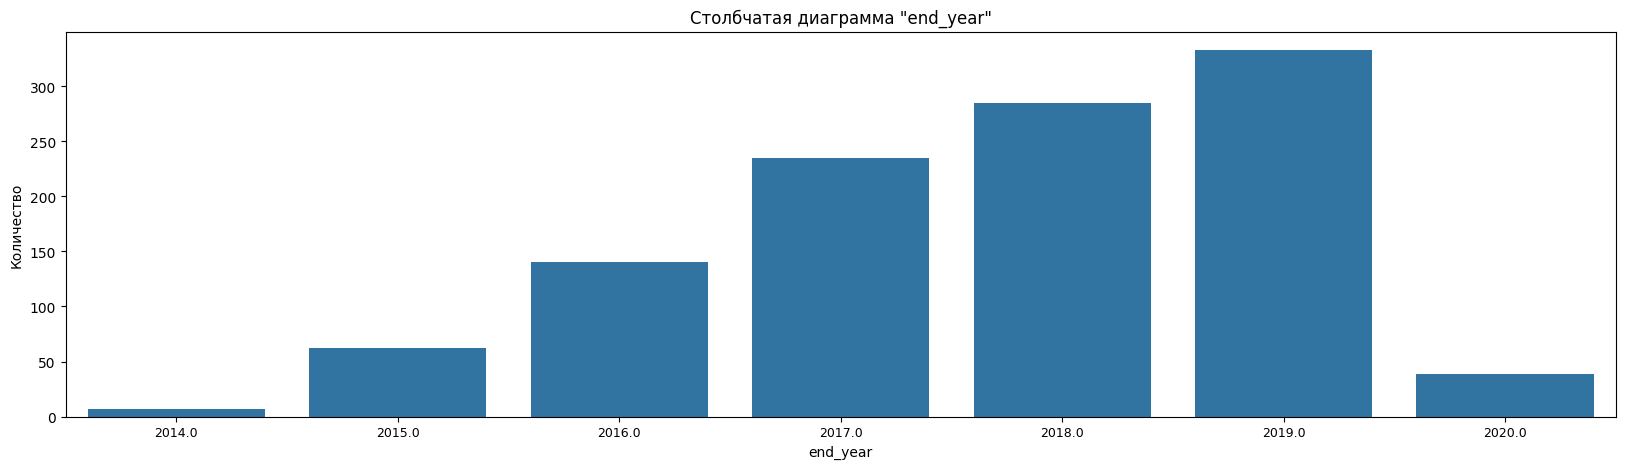

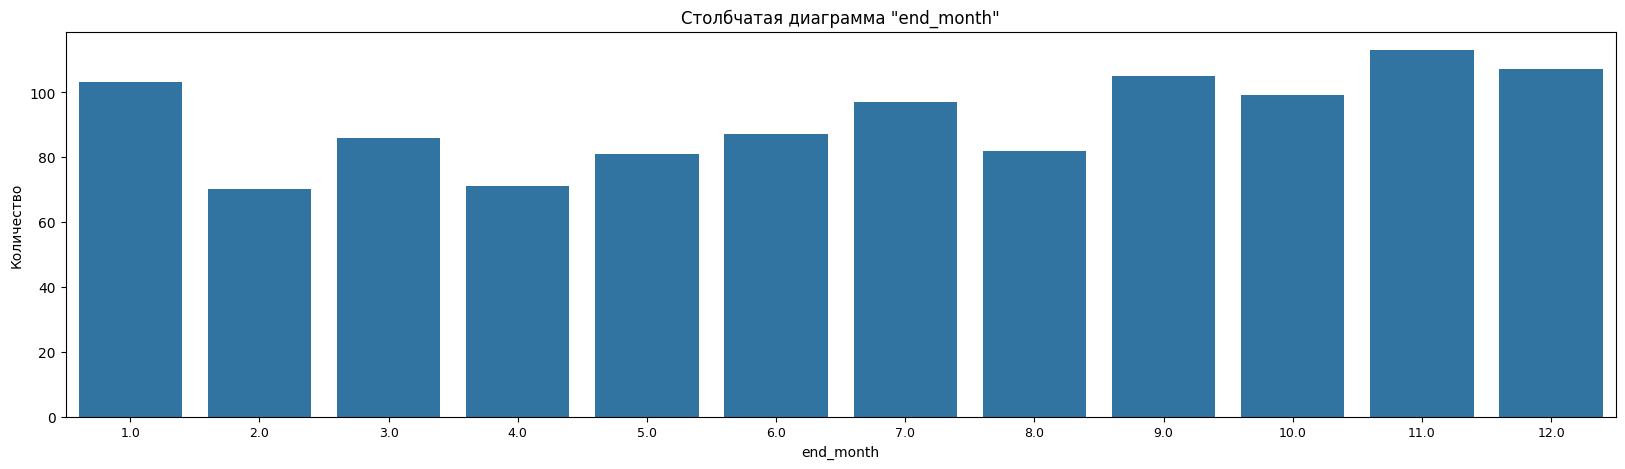

In [46]:
# Создадим дополнительные колонки - с годом и месяцем расторжения договора на услуги связи и 
# построим столбчаты диаграммы
df_merged['end_year'] = pd.to_datetime(df_merged.loc[df_merged['end_date']!='No']['end_date'], format='%Y-%m-%d').dt.year
df_merged['end_month'] = pd.to_datetime(df_merged.loc[df_merged['end_date']!='No']['end_date'], format='%Y-%m-%d').dt.month
for column in ['end_year', 'end_month']:
    plt.figure(figsize=(20, 5))
    sns.countplot(
    data=df_merged,
    x=column
    )
    plt.title(f'Столбчатая диаграмма "{column}"')
    plt.xlabel(f'{column}')
    plt.ylabel('Количество')
    plt.xticks(fontsize=9)
    plt.show()

- с каждым годом количество расторженных договоров увеличивается
- наибольшее количество расторженных договоров приходится на месяца с сентябрь по январь

Построим гистограммы 'monthly_charges', 'total_charges', 'duration_days' в зависимости от факта расторжения договора:

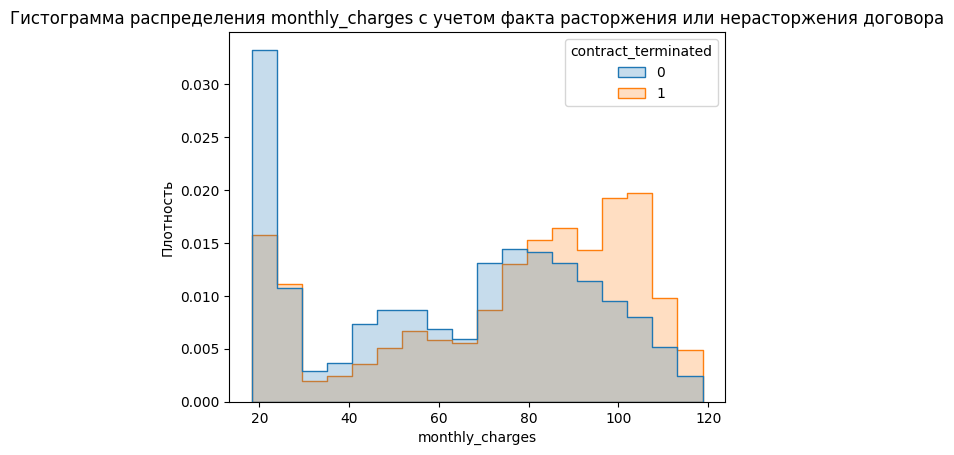

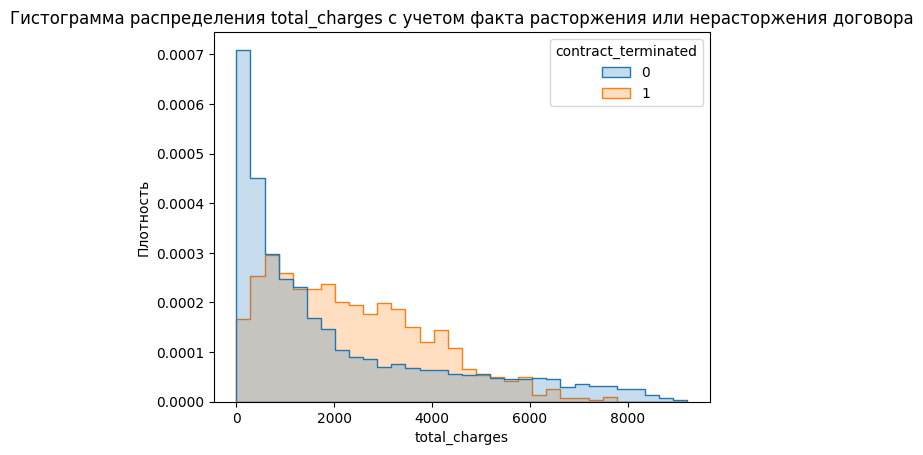

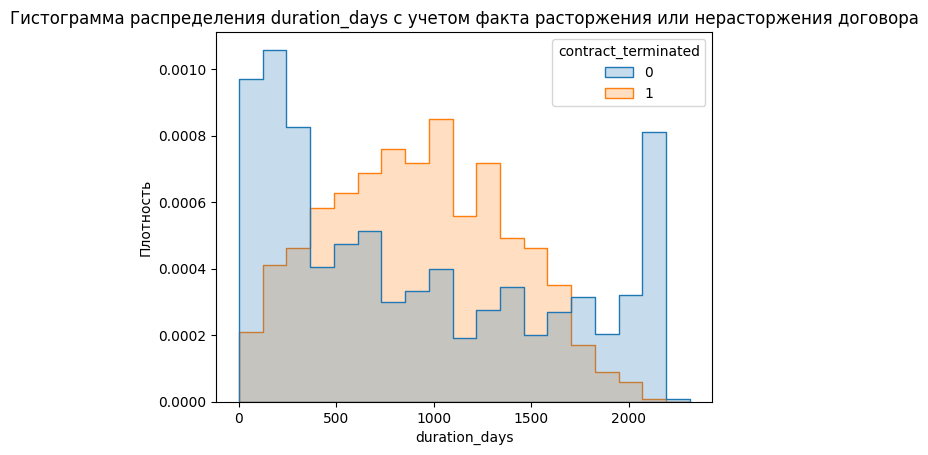

In [47]:
# Построим гистограммы 'monthly_charges', 'total_charges', 'duration_days' в зависимости от факта расторжения договора
col_for_hist = ['monthly_charges', 'total_charges', 'duration_days']
for column in col_for_hist:
    sns.histplot(data=df_merged, 
                 x=column, 
                 stat='density', 
                 common_norm=False,
                 element='step',
                 hue='contract_terminated')
    plt.title(f'Гистограмма распределения {column} с учетом факта расторжения или нерасторжения договора')
    plt.xlabel(f'{column}')
    plt.ylabel('Плотность')
    plt.show()

- Основное различием в гистограммах 'monthly_charges' и 'total_charges'- отсутствие пика на низких значениях для клиентов, расторгших договор, что говорит о том, что клиенты с низкими расходами на услуги связи реже расторгают договор.  
- На гистограмме duration_days для клиентов, расторгших договор наблюдается пик на значении около 1000, спадающий в сторону увеличения и уменьшения значения 'duration_days', что говорит о том, что клиенты, заключившие договор относительно недавно (менее 2-х лет), а также клиенты со сроком действия договора более 5 лет редко расторгают договор. Макисмум расторжений договоров приходится на срок около 3-х лет.  

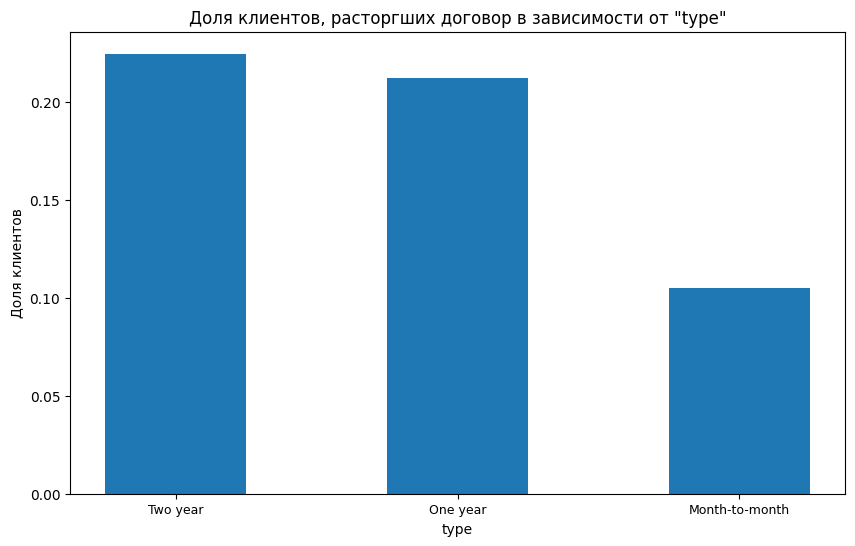

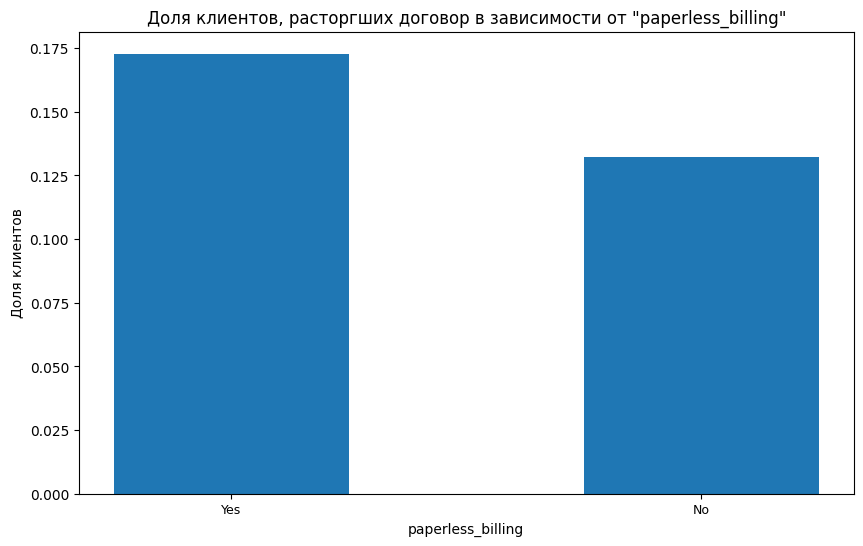

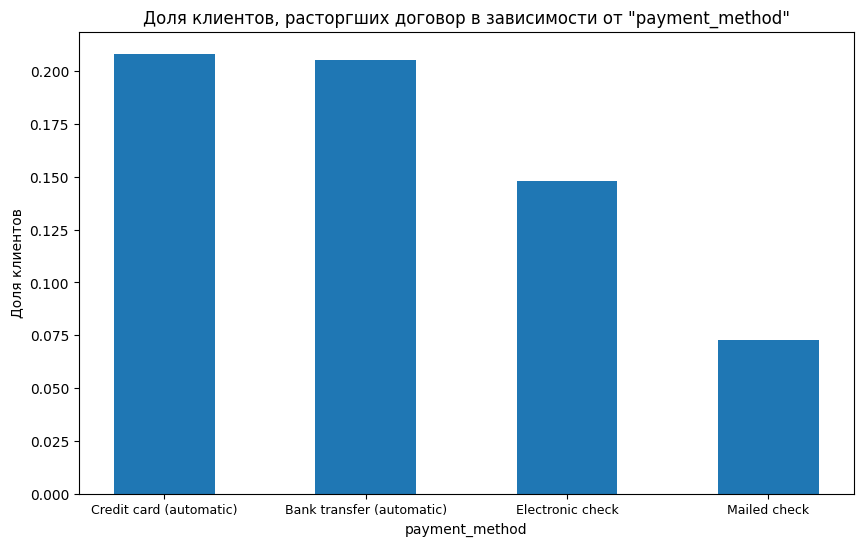

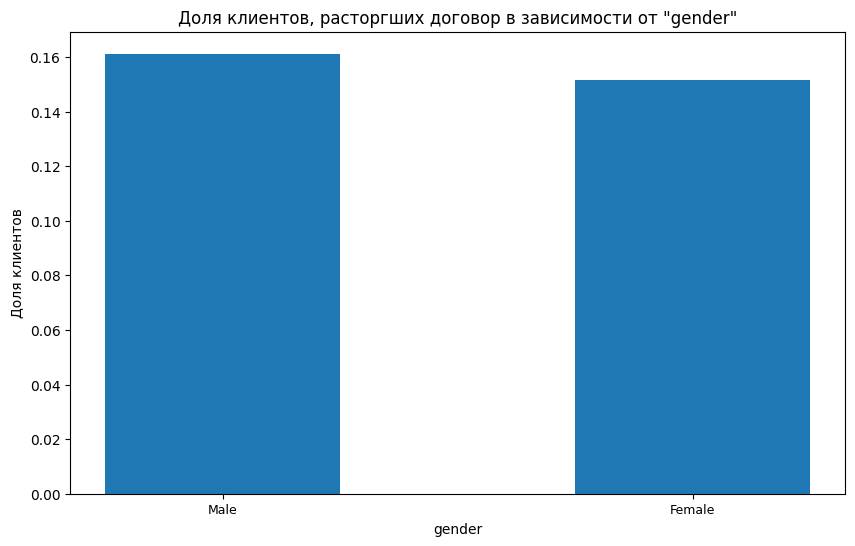

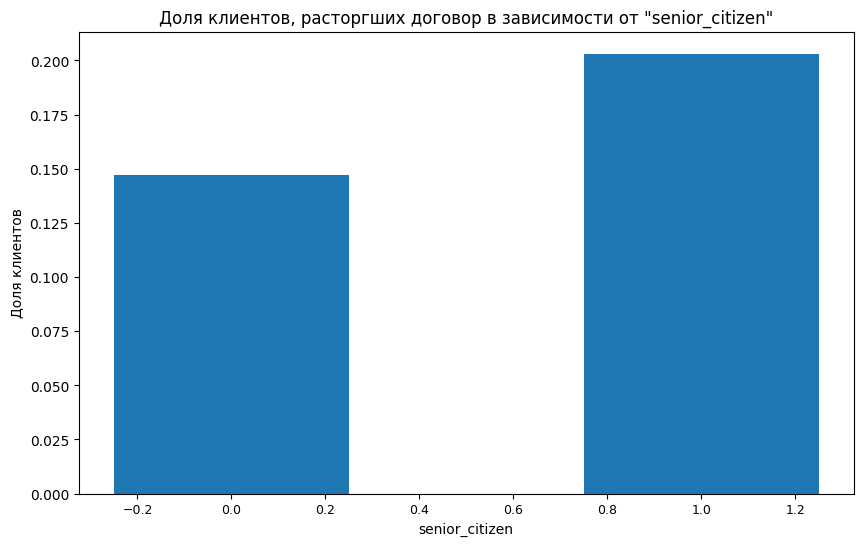

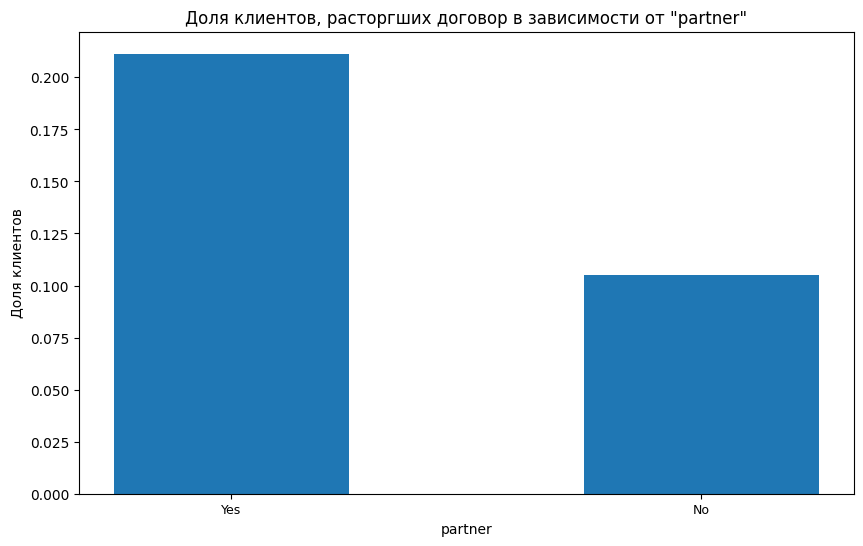

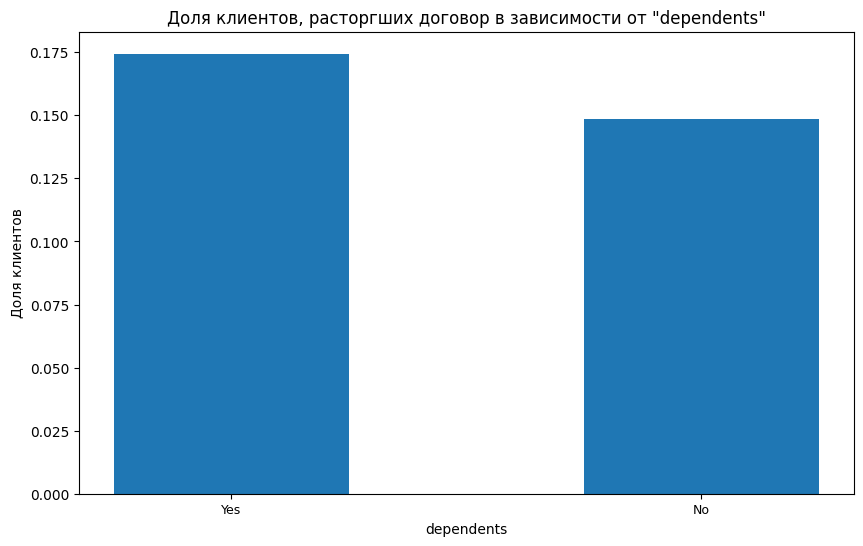

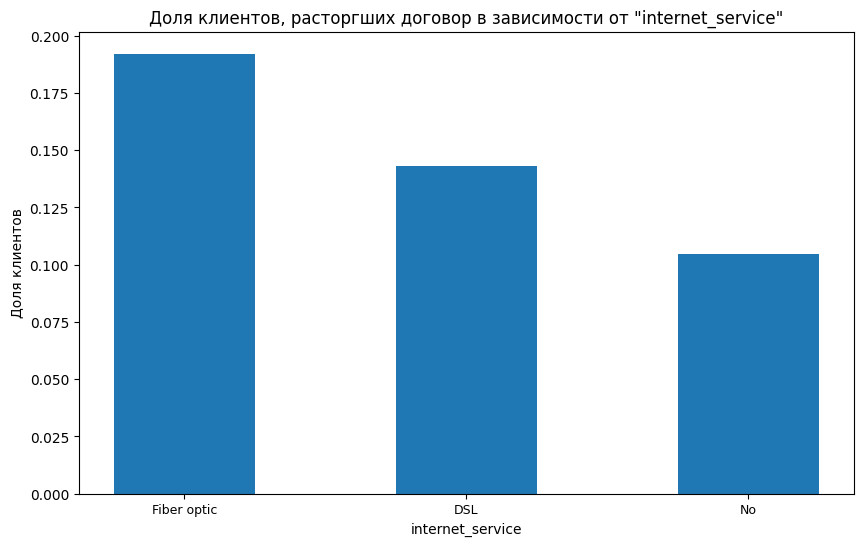

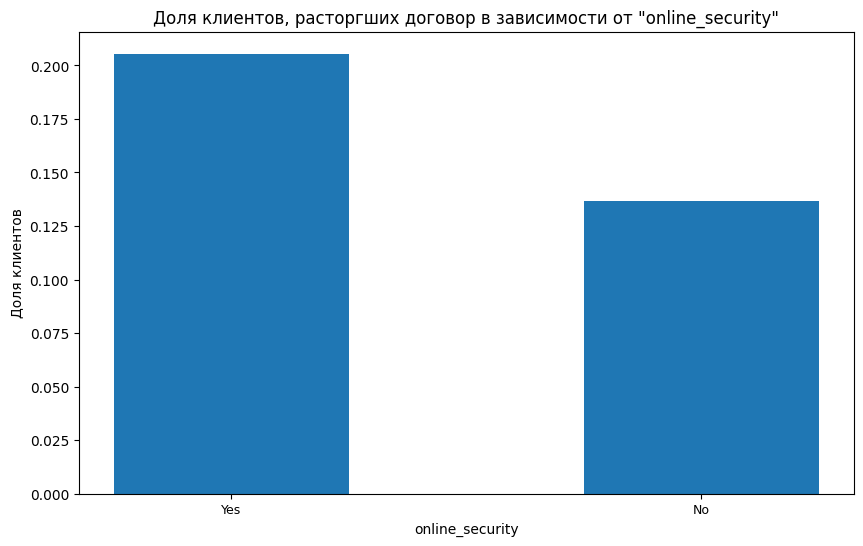

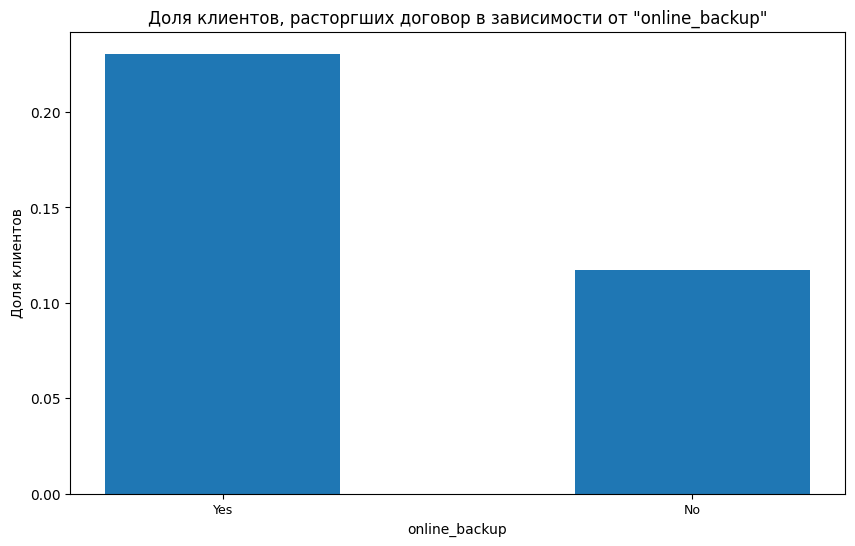

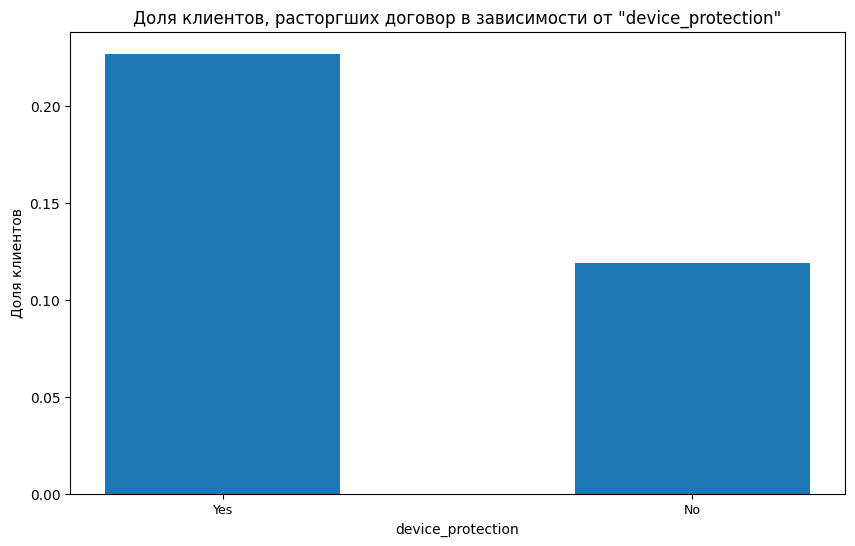

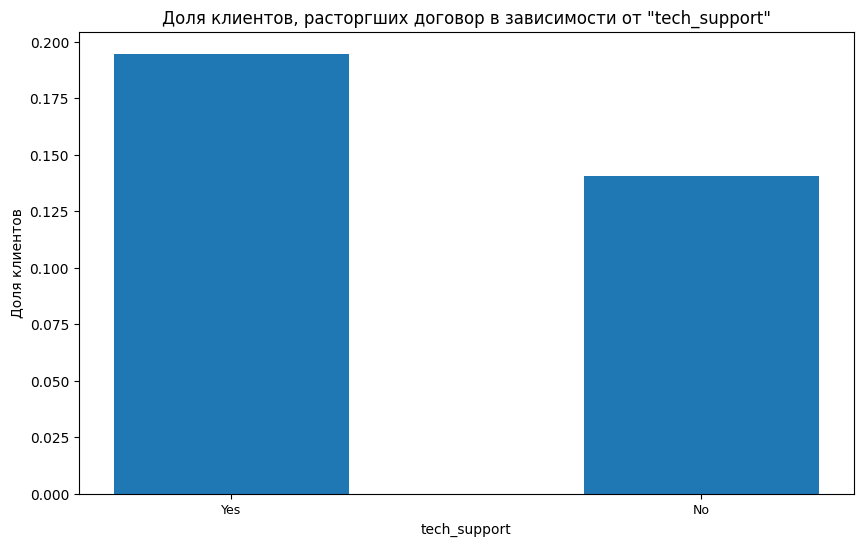

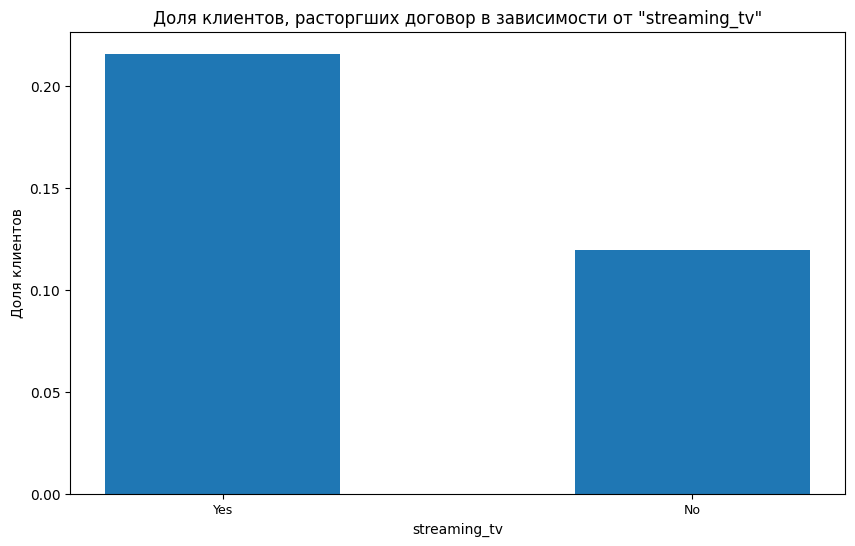

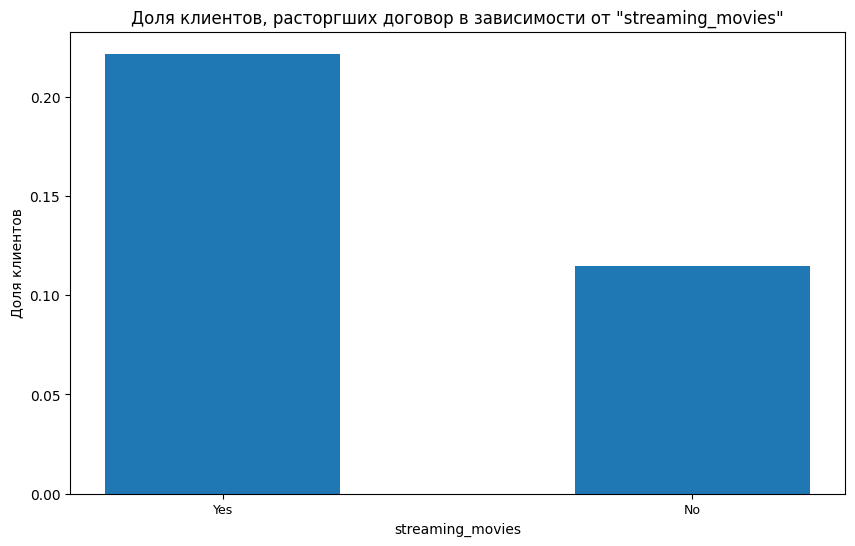

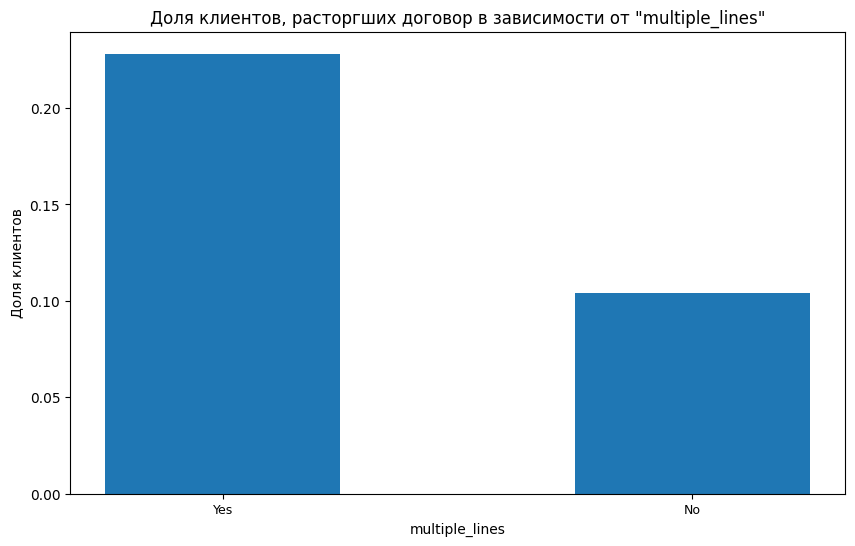

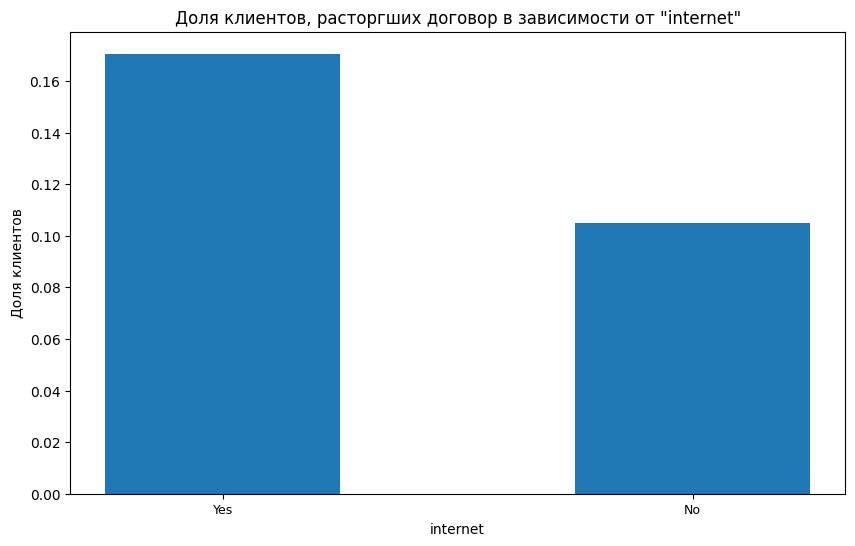

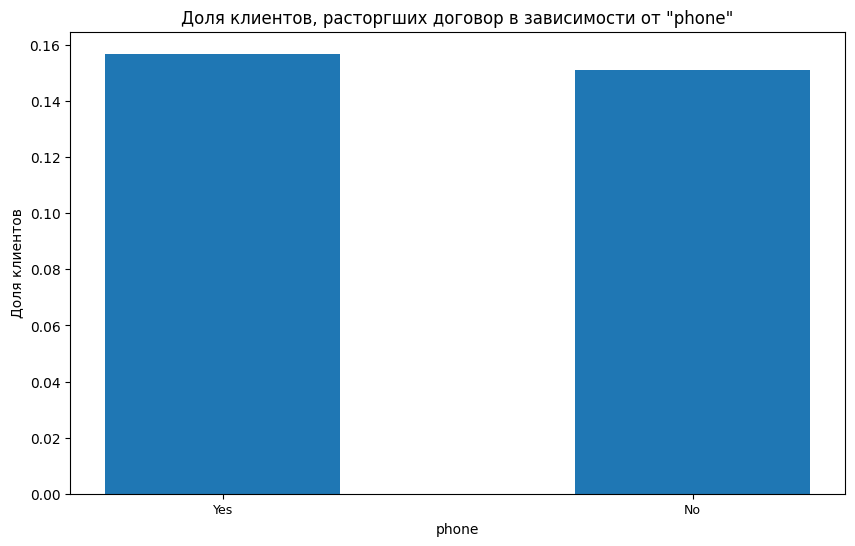

In [48]:
#Посчитаем сотношение пользователей с подпиской и без
for column in cat_columns:
    if column != 'contract_terminated':
        clients_grouped = df_merged.pivot_table(index = column, values='contract_terminated', aggfunc='mean'). \
                                                        sort_values('contract_terminated', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.bar(clients_grouped.index, clients_grouped['contract_terminated'], width=0.5)
        plt.title(f'Доля клиентов, расторгших договор в зависимости от "{column}"')
        plt.xlabel(f'{column}')
        plt.ylabel('Доля клиентов')
        plt.xticks(fontsize=9)
        plt.show()

Из приведенных диаграмм видно, что доля расторгших договор меньше - среди клиентов:  
    - с типом оплаты "month-to-month"  
    - не пользующихся электронным расчетным листом    
    - с типом платежа 'Mailed check' и 'Electronic check'  
    - не являющихся пенсионерами  
    - не состоящие в браке  
    - без детей  
    - не пользующихся доп услугами  
    - не пользующихся интернетом  

**Выводы по исследовательскому анализу данных:**  

- клиенты с низкими расходами на услуги связи реже расторгают договор  
- клиенты, заключившие договор относительно недавно (менее 2-х лет), а также клиенты со сроком действия договора более 5 лет редко расторгают договор. Макисмум расторжений договоров приходится на срок около 3-х лет

Доля расторгших договор клиентов меньше:  

- с типом оплаты "month-to-month"  
- не пользующихся электронным расчетным листом    
- с типом платежа 'Mailed check' и 'Electronic check'  
- не являющихся пенсионерами  
- не состоящие в браке  
- без детей  
- не пользующихся доп услугами  
- не пользующихся интернетом  

При обучение моделей необходимо учесть дисбаланс целевого признака 'contract_terminated' ('1' - 16 %, '0' - 84 %)    

## Корреляционный анализ

Построим phik-матрицу, исключив из анализа колонки с датами:

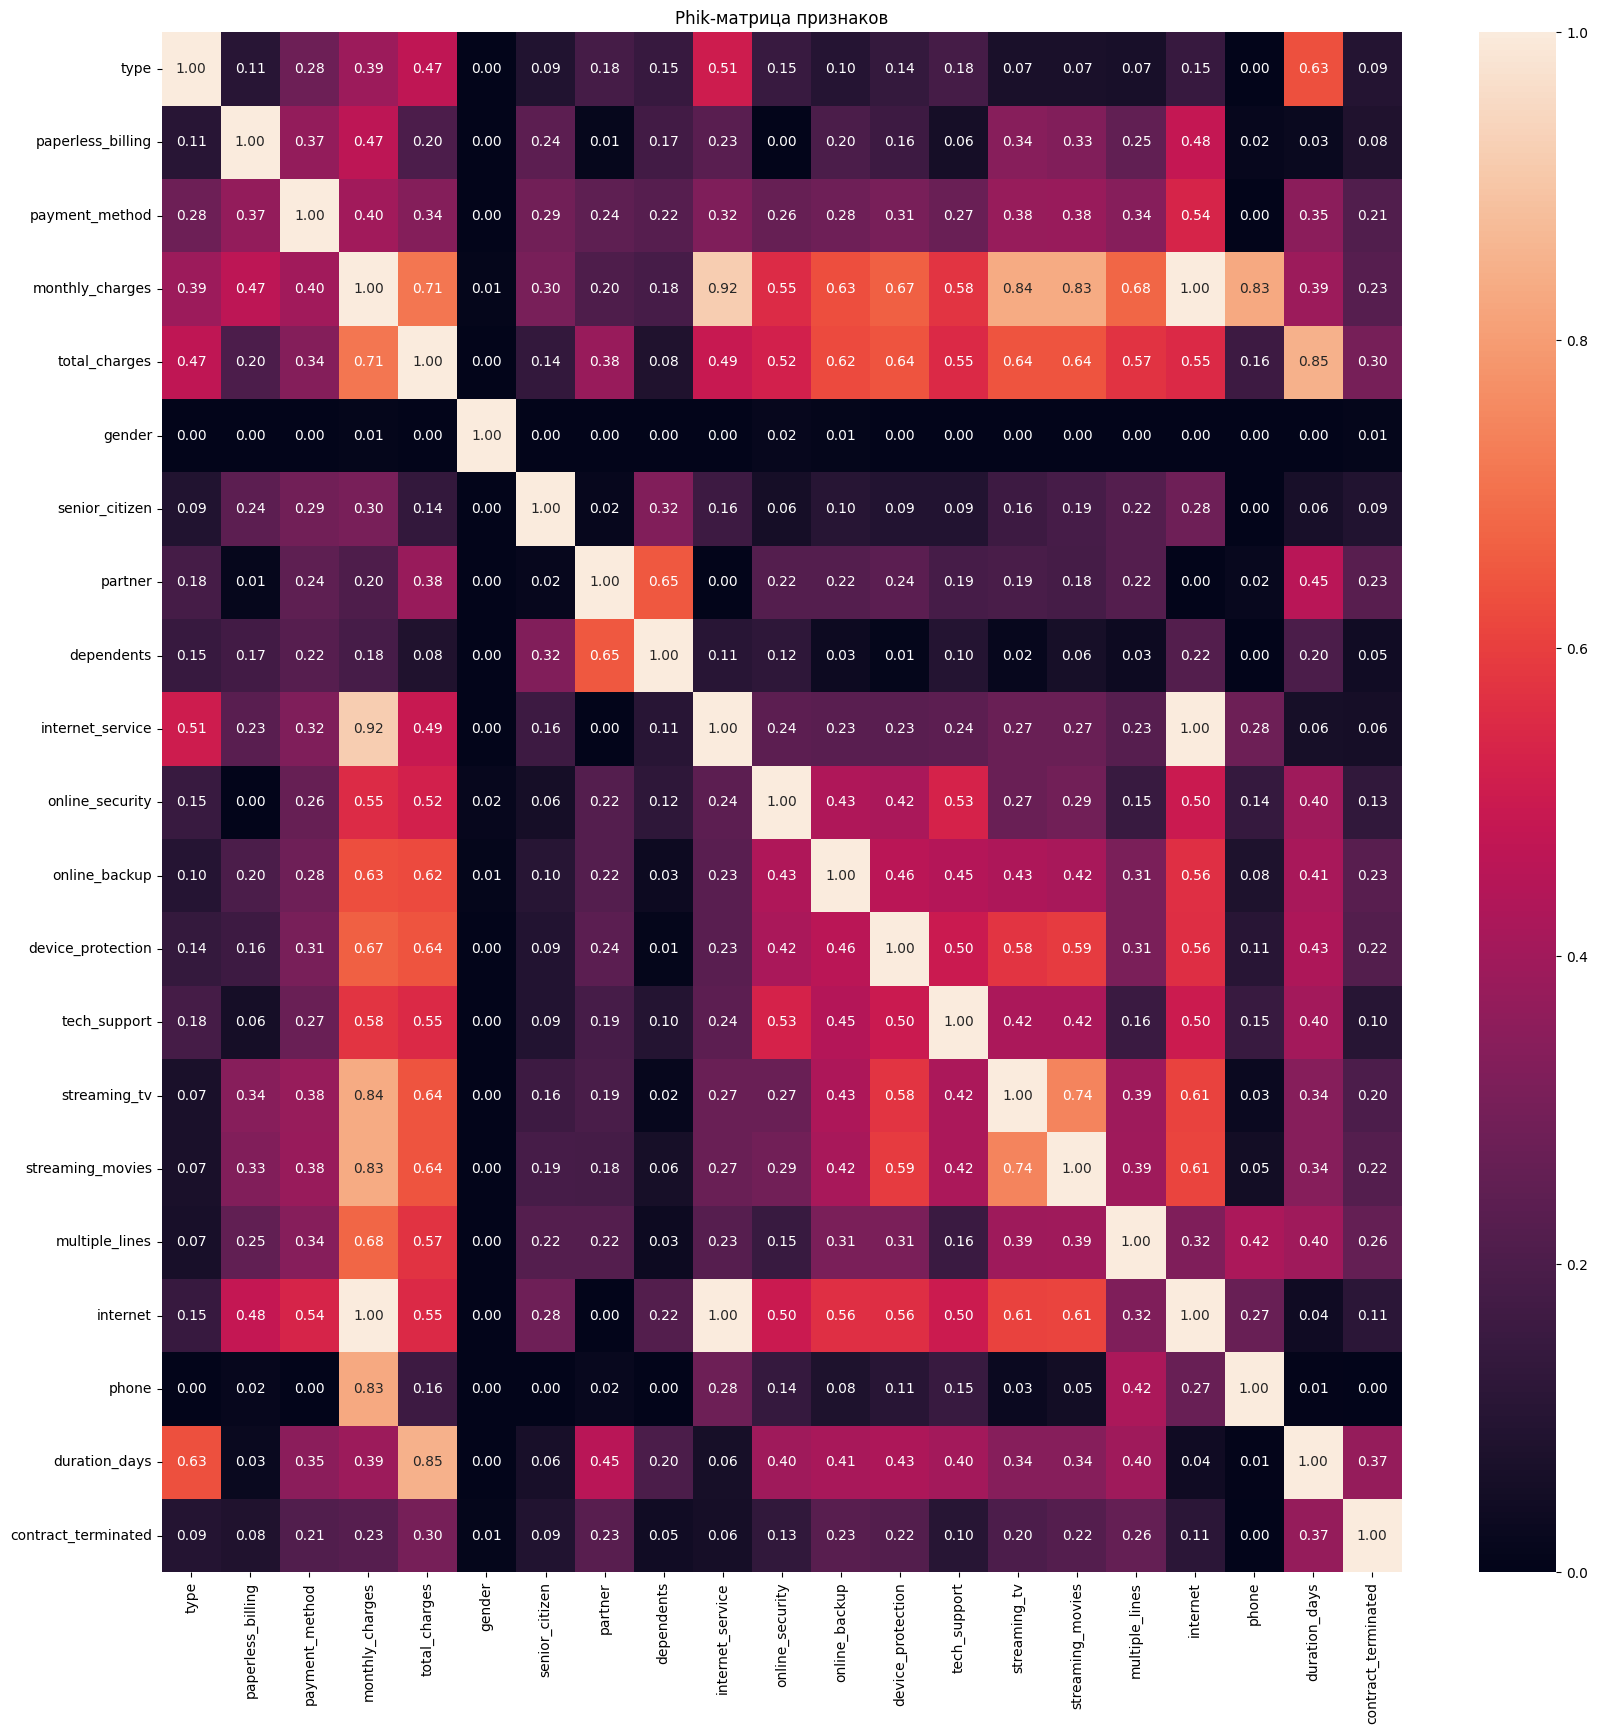

In [49]:
columns_for_drop = ['begin_year',
                    'end_year',
                    'begin_month',
                    'end_month',
                    'current_date',
                    'begin_date',
                    'end_date',
                    ]
plt.figure(figsize=(20,20))
sns.heatmap(df_merged.drop(columns_for_drop, axis=1). \
            phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration_days']),  
            annot=True, fmt='.2f')
plt.title(f'Phik-матрица признаков')
plt.show()

Для устранения мультиколлинеарности удалим признак 'internet':

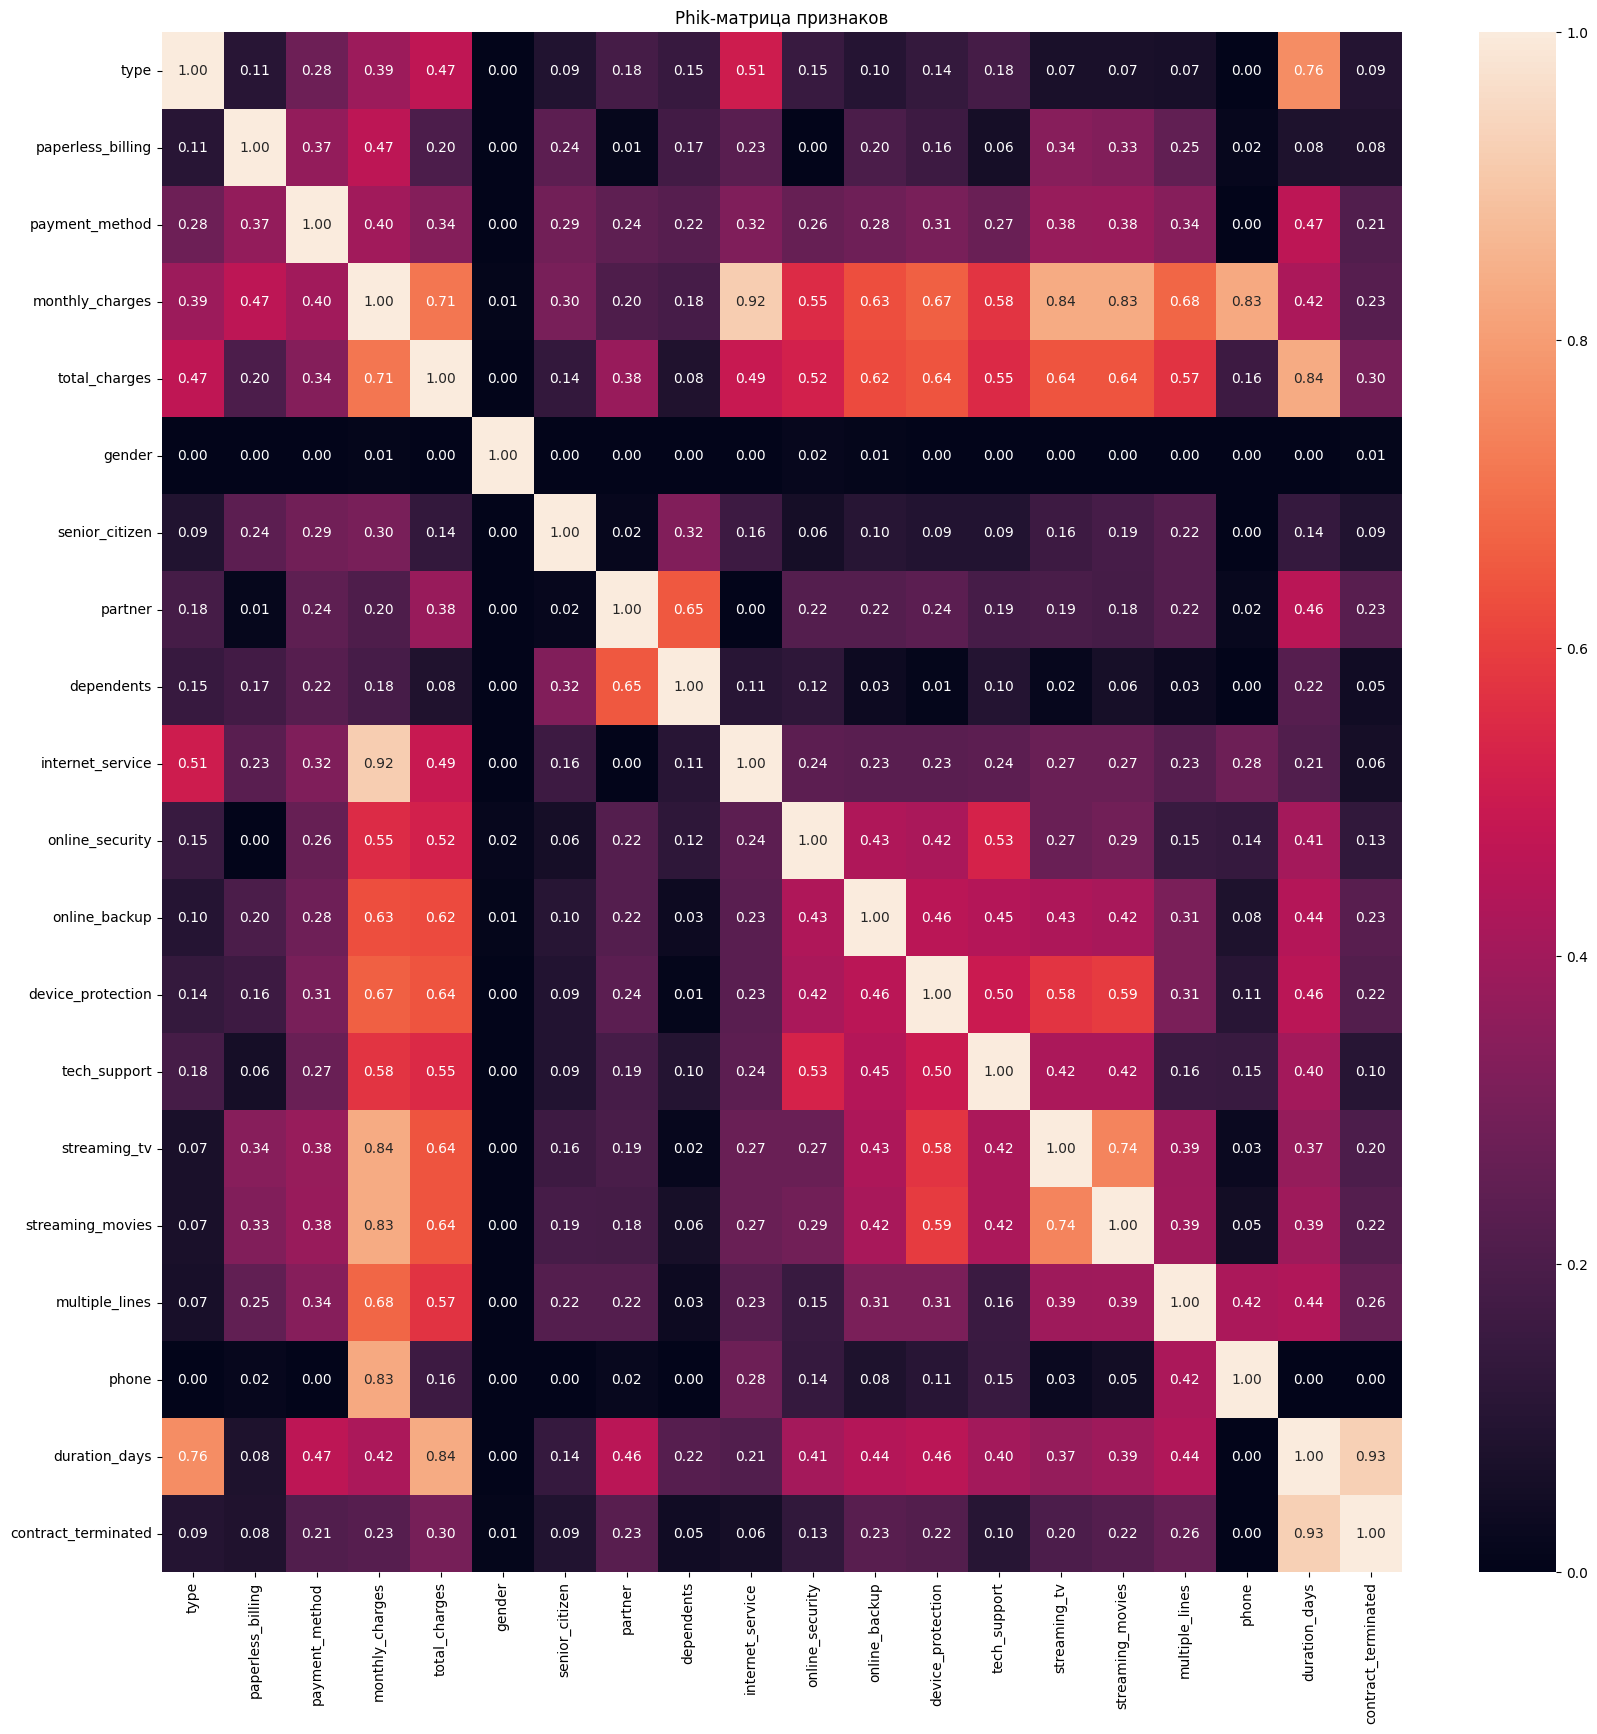

In [50]:
# Добавим к списку признаков для исключения признак 'internet'
columns_for_drop.append('internet')

plt.figure(figsize=(20,20))
sns.heatmap(df_merged.drop(columns_for_drop, axis=1). \
            phik_matrix(interval_cols=['monthly_charges', 'total_charges']),  
            annot=True, fmt='.2f')
plt.title(f'Phik-матрица признаков')
plt.show()

Целевой признак is_client сильнее всего коррелирует с:  
- 'duration_days' (к.кор 0.93)
- 'total_charges' (к.кор 0.30)
- 'multiple_lines' (к.кор 0.26)
- 'monthly_charges' (к.кор 0.23)
- 'partner' (к.кор 0.23)
- 'device_protection' (к.кор 0.22)
- 'streaming_movies' (к.кор 0.22)
- 'payment_method' (к.кор 0.21)
- 'streaming_tv' (к.кор 0.20)  

Таким образом, главным фактором, влияющим на факт расторжения договора, является длительность действия договора на текущий момент. Также ожидаемо влияют расходы и набор услуг (зависимые величины), наличие супруга, способ оплаты и тд

## Обучение моделей

Подготовим данные для обучения:

In [51]:
# Удалим из датафрема лишние признаки
df_merged = df_merged.drop(columns_for_drop, axis=1)

In [52]:
df_merged.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone,duration_days,contract_terminated
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,No,31,0
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,Yes,1036,0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes,123,0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,No,1371,0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,Yes,153,0


In [53]:
# Разделим датафрейм на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_merged.drop('contract_terminated', axis=1),
    df_merged['contract_terminated'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_merged['contract_terminated'] # добавил стратификаию по целевому признаку
)

In [54]:
# Список с категориальными признаками для OneHotEncoder
ohe_columns = ['type',
               'payment_method',
               'gender',
               'internet_service'
              ]

# Список с категориальными признаками для OrdinalEncoder
ord_columns = ['paperless_billing', 
               'partner', 
               'dependents', 
               'online_security',
               'online_backup',
               'device_protection',
               'tech_support',
               'streaming_tv',
               'streaming_movies',
               'multiple_lines',
               'phone'
              ]

# Список с количественными признаками
num_columns = ['monthly_charges', 'total_charges', 'duration_days']

In [55]:
#Создаем пайплайн для OneHotEncoder
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[['No', 'Yes']] * len(ord_columns),
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [56]:
# Пайплайн для кодирования категориальных признаков и масштабирования количественных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Создаем пайплайн, объединяющий в себе препроцессинг и обучение модели
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
]) 

Протестируем три модели: DecisionTreeClassifier(), LogisticRegression(), RandomForestClassifier() и CatBoostClassifier. Балансировку классов не включаем, поскольку целевая метрика, ROC-AUC, нечувствительна к дисбалансу классов.

In [57]:
param_grid = [
    # DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(
            random_state=RANDOM_STATE,
        )],
        'models__max_depth': [2, 4, 6, None],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 5],
        'preprocessor__num': ['passthrough']
    },

    # LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            max_iter=2000
        )],
        'models__C': [0.01, 0.1, 1, 5, 10],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    # RandomForestClassifier
    {
        'models': [RandomForestClassifier(
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=-1
        )],
        'models__n_estimators': [300, 500, 1000],
        'models__max_depth': [3, 5, 7, None],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'preprocessor__num': ['passthrough']
    },

    # CatBoostClassifier
    {
        'models': [CatBoostClassifier(
            random_state=RANDOM_STATE,
            verbose=False
        )],
        'models__iterations': [200, 500, 1000],
        'models__depth': [4, 6, 8],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__l2_leaf_reg': [1, 3, 5],
        'preprocessor__num': ['passthrough']
    }
]

In [58]:
%%time
# Считаем кросс-валидацию с перебором гиперпараметров масштабирования и модели
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.impute._base")

grid = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring=['roc_auc', 'accuracy'],
    refit='roc_auc',
    n_jobs=-1,
    verbose=1,
)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 245 candidates, totalling 1225 fits
CPU times: total: 48.2 s
Wall time: 30min 37s


c:\users\тимур\appdata\local\programs\python\python39\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['type',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'internet_service']),
                                                                        ('ord',
                                                                         Pipel...
                          'models__n_estimators': [300, 500, 1000],
                          'preprocessor__num': ['passthrough']},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x000002CE53FE5C70>],
                          'models__depth': [4, 6, 8],
                          'models__iterations': [200, 500, 1000],
                          'models__l2_leaf_reg': [1, 3, 5],
                          'models__learning_rate': [0.01, 0.05, 0.1],
                          'preprocessor__num': ['passthrough']}],
             refit='roc_auc', scoring=['roc_auc', 'accuracy'], verbose=1)

In [59]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print(f"Метрика ROC-AUC для лучшей модели: {grid.best_score_:.4f}")
print(f"Метрика Accuracy для лучшей модели: {grid.cv_results_['mean_test_accuracy'][grid.best_index_]:.4f}")

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type', 'payment_method',
                                                   'gender',
                                                   'internet_service']),
                             

In [60]:
# Параметры лучшей модели
best_model = grid.best_estimator_.named_steps['models']
params_dict = best_model.get_params()

params_df = pd.DataFrame(params_dict.items(), columns=['Parameter', 'Value'])

In [61]:
print('Параметры лучшей модели CatBoostClassifier:')
display(params_df)

Параметры лучшей модели CatBoostClassifier:


,Parameter,Value
0,verbose,False
1,random_state,80925
2,depth,4
3,iterations,1000
4,l2_leaf_reg,3
5,learning_rate,0.1


In [62]:
y_test_pred = grid.predict(X_test)

In [63]:
# Запишем вероятности в переменную
y_test_proba = grid.predict_proba(X_test)[:, 1]

In [64]:
#Выведем метрики на тестовой выборке
print(f'Метрика ROC-AUC на тестовой выборке: {(roc_auc_score(y_test, y_test_proba))}')
print(f'Метрика Accuracy на тестовой выборке: {(accuracy_score(y_test, y_test_pred))}')

Метрика ROC-AUC на тестовой выборке: 0.9341172152208491
Метрика Accuracy на тестовой выборке: 0.9278818852924475


Таким образом, лучший результат показала модель **CatBoostClassifier(iterations=1000, depth=4, l2_leaf_reg=3, learning_rate=0.1, auto_class_weights='Balanced', random_state=80925))])**. На тестовой выборке данная модель показала метрику ROC-AUC, равную **0.93** и значение Accuracy, равное 0.93.    

**Интерпретация значений полученных метрик:**  
Полученное значение ROC-AUC, равное 0.93 значает, что в 93 % случаев модель правильно различит клиентов из разных классов.
Полученное значение Accuracy = 0.93 означает, что доля всех клиентов, которых модель классифицировала верно, равна 93 %.

Сравнение результата с результатом прдесказания констатной модели (DummyClassifier):

In [65]:
# Инициализируем DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)

# Обучим модель и прескажем значения
dummy_clf.fit(X_train, y_train)
y_dummy_pred = dummy_clf.predict(X_test)

# Запишем вероятности в отдельную переменную:
y_dummy_proba = dummy_clf.predict_proba(X_test)[:, 1]

In [66]:
#Выведем метрики на тестовой выборке DummyClassifier
print(f'DummyClassifier ROC-AUC: {(roc_auc_score(y_test, y_dummy_proba))}')
print(f'DummyClassifier Accuracy: {(accuracy_score(y_test, y_dummy_pred))}')

DummyClassifier ROC-AUC: 0.5168848647987275
DummyClassifier Accuracy: 0.7473026689381034


Получено ожидаемое значение ROC-AUC, равное 0.52 (случайное угадывание класса) - то есть в 52 % случаев модель правильно различит между собой двух клиентов из разных классов.  
Метрика Accuracy, равная 0.74, говорит о том, что при случайном угадывании с учетом дисбаланса классов, в 74 % случаев предсказание будет верным. Данное значение меньше, чем показала обученная модель (0.93).

Таким образом, обученная модель показывает лучшей результат, чем константная.

## Матрица ошибок

### Матрица ошибок для обученной модели

Построим матрицу ошибок и посчитаем дополнительные метрики:

Text(0.5, 23.52222222222222, 'Predicted')

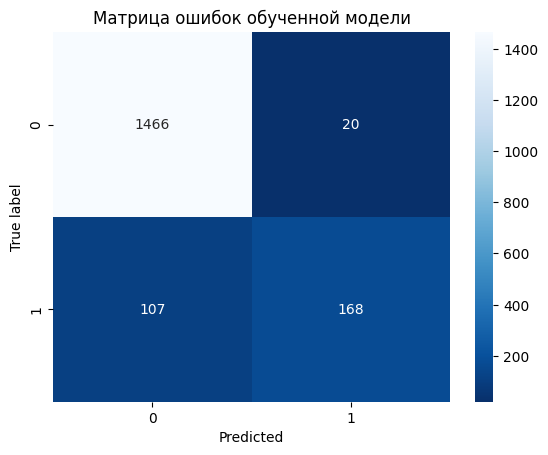

In [67]:
# Матрицца ошибок
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title(f'Матрица ошибок обученной модели')
plt.ylabel('True label')
plt.xlabel('Predicted')

In [68]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_test_pred))
# Precision
print("Precision:", precision_score(y_test, y_test_pred))
# Recall
print("Recall:", recall_score(y_test, y_test_pred))
# f1_score
print("f1_score:", f1_score(y_test, y_test_pred))

Accuracy: 0.9278818852924475
Precision: 0.8936170212765957
Recall: 0.610909090909091
f1_score: 0.7257019438444925


**Интерпретация результатов**

- Из 1486 клиентов, не расторгнувшх договор, модель верно определила 1466, неверно - 20 (98.6 % верных предсказаний)
- Из 275 клиентов, расторгших договор, модель определила верно 168, неверно 107 (61 % верных предсказаний)
- Из  1573 клиентов, которых модель классифицировала, как нерасторгших договор, 1466 предсказаний верны, 107 - неверны (93 % верных предсказаний)
- Из 188 человек, которых модель классифицировала, как расторгших договор, 168 предсказаний верны, 20 - неверны (89 % верных предсказаний)

Таким образом:
- в 93 % случаев модель классифицировала клиентов верно (метрика Accuracy)
- в 89 % случаев модель верно классифицировала клиентов, расторгнувших договор (метрика Precision)
- модель нашла 61 % клиентов, которые расторгли договор (метрика Recall)
- метрика f1-score = 0.73 показывает, что модель достаточно хорошо находит клиентов, которые расторгнут договор, и при этом не делает слишком много ошибочных предупреждений (максимальное значение - 1 (идеальный результат), минимальное - 0 (очень плохой результат)).

### Матрица ошибок для константной модели (DummyClassifier)

Text(0.5, 23.52222222222222, 'Predicted')

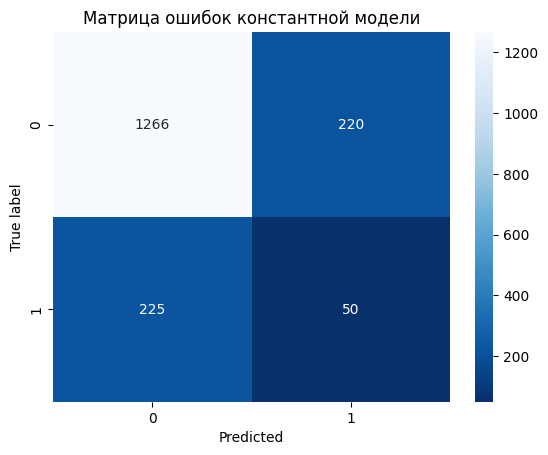

In [69]:
# Матрицца ошибок
cm = confusion_matrix(y_test, y_dummy_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title(f'Матрица ошибок константной модели')
plt.ylabel('True label')
plt.xlabel('Predicted')


In [70]:
# Accuracy
print("Константная модель Accuracy:", accuracy_score(y_test, y_dummy_pred))
# Precision
print("Константная модель Precision:", precision_score(y_test, y_dummy_pred))
# Recall
print("Константная модель Recall:", recall_score(y_test, y_dummy_pred))
# f1_score
print("Константная модель f1_score:", f1_score(y_test, y_dummy_pred))

Константная модель Accuracy: 0.7473026689381034
Константная модель Precision: 0.18518518518518517
Константная модель Recall: 0.18181818181818182
Константная модель f1_score: 0.1834862385321101


**Интерпретация метрик для константной модели**
- в 74 % случаев модель классифицировала клиентов верно (метрика Accuracy)
- в 18 % случаев модель верно классифицировала клиентов, расторгнувших договор (метрика Precision)
- модель нашла 18 % клиентов, которые расторгли договор (метрика Recall)
- метрика f1-score = 0.18 показывает, что модель достаточно плохо находит клиентов, которые расторгнут договор, и делает слишком много ошибочных предупреждений (максимальное значение - 1 (идеальный результат), минимальное - 0 (очень плохой результат)).

Таким образом, обученная модель гораздо лучше выполняет задачу классификации клиентов, чем константная модель.

## Анализ важности признаков

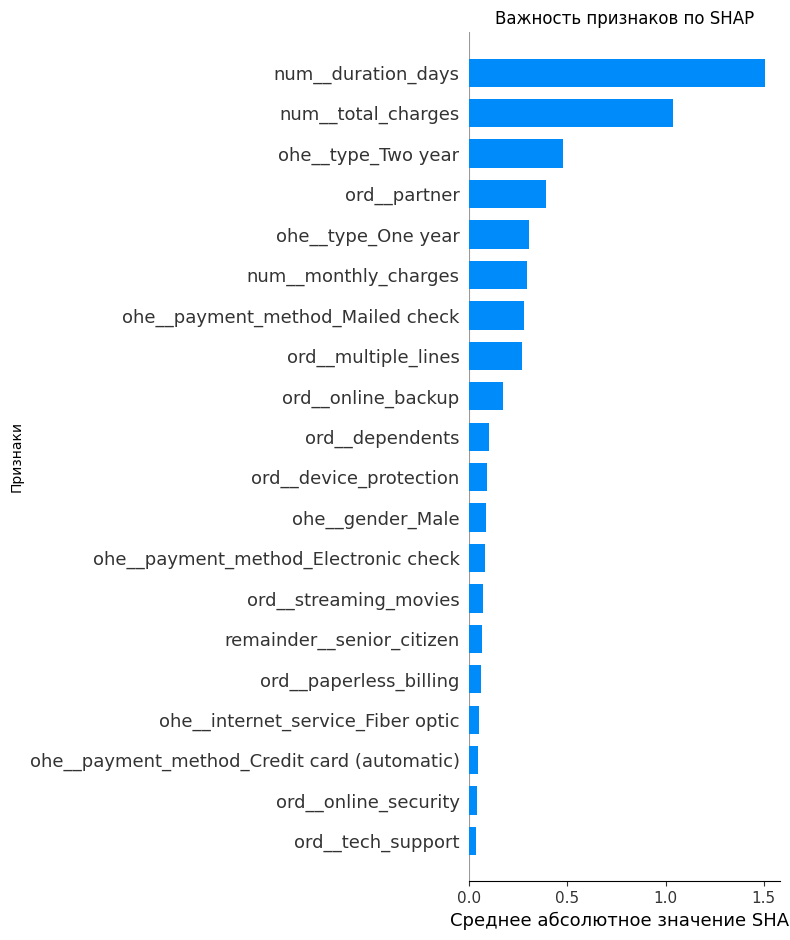

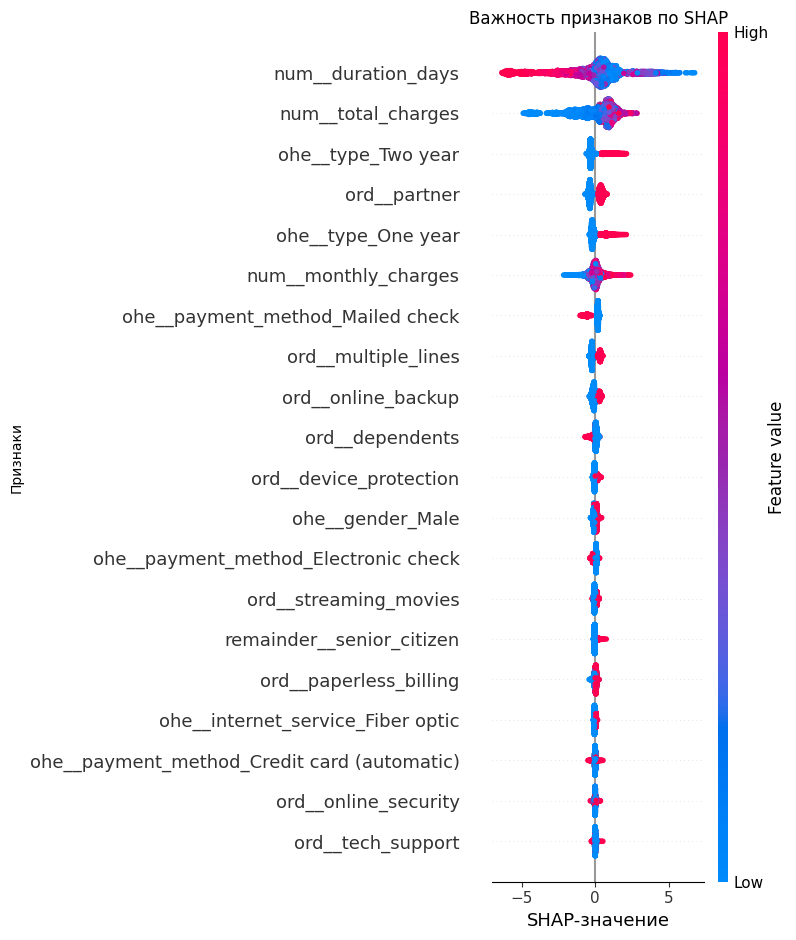

In [71]:
# Получаем лучшую модель
best_model = grid.best_estimator_

# Получаем обработанные данные
X_train_processed = best_model.named_steps['preprocessor'].transform(X_train)

# Получаем названия признаков
try:
    # Пытаемся получить названия из imputer
    labels = best_model.named_steps['preprocessor'].get_feature_names_out()
except:
    # Если не работает, используем исходные названия колонок
    labels = X_train.columns.tolist()

explainer = shap.TreeExplainer(best_model.named_steps['models'])

# SHAP values
shap_values = explainer.shap_values(X_train_processed)

# Визуализации
shap.summary_plot(shap_values, X_train_processed, 
                 feature_names=labels, 
                 plot_type="bar",
                 max_display=20,
                 show=False)
plt.title("Важность признаков по SHAP")
plt.ylabel("Признаки")
plt.xlabel("Среднее абсолютное значение SHAP")
plt.tight_layout()
plt.show()



shap.summary_plot(shap_values, X_train_processed,
                 feature_names=labels,
                 max_display=20,
                 show=False)
plt.title("Важность признаков по SHAP")
plt.xlabel("SHAP-значение")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

Из представленных графиков видим, что сильнее всего влияют следующие признаки:  
- duration_days (длительность договора). При высоких значениях данного признака уменьшается вероятность расторжения договора  
- type (Тип оплаты). Для клиентов с типом оплаты 'Two year' и 'One year' выше веротяность расторжения договора  
- partner (наличие супруга/супруги). Для клиентов с супругой/супругом выше веротяность расторжения договора  
- total_charges (общие расходы абонента). Для низких значений ниже вероятность расторжения договора  
- multiple_lines (подключение телефона к нескольким линиям одновременно). Для клиентов с подключенной услугой выше веротяность расторжения договора  
- monthly_charges (ежемесячные расходы). Чем ниже ежемесячные расходы, тем ниже вероятность расторжения договора  
- payment_method (тип платежа). Для типа платежа 'Mailed check' ниже вероятность расторжения договора

Результаты анализа важности признаков, в целом, согласуются c выводами, сделанными в разделе "Исследовательский анализ".

## Общий вывод и рекомендации заказчику

**Загрузка данных** 

Загружено 4 с персональной информацией (personal_new.csv), информацией о договорах (contract_new.csv), информацией об интернет услугах (internet_new.csv) и услугах телефонии (phone_new.csv) и выполнен первичный анализ входной информации.

**Объединение данных и их предобработка** 

На данном этапе было выполнено объединение данных и предобработка, включающая в себя проверку данных на некорретные значения, поиск дубликатов, изменение типов данных, создание новых признаков тд.

**Исследовательский анализ** 

На данном этапе анализировались распределения входных признаков, в том числе, в зависимости от значения целевого признака.

**Корреляционный анализ**

Был выполнен анализ зависимости целевого признака от входных,устранена мультиколлинеарность между входными признаками, выполнен отбор входных признаков.

**Обучение моделей**

Было выполнено тестирование моделей классфикации LogisticRegression, DecisionTreeClessifier, RandomForestClassifier и CatBoostClassifier с перебором гиперпараметров. 
    Лучший результат показала модель **CatBoostClassifier(iterations=1000, depth=4, l2_leaf_reg=1, learning_rate=0.1, auto_class_weights='BAlansed', random_state=80925))])**. На тестовой выборке данная модель показала метрику ROC-AUC, равную **0.93**, и Accuracy, равную **0.93**, что удовлетворяет требованию задачи.

Полученное значение ROC-AUC, равное 0.93 значает, что в 93 % случаев модель правильно различит клиентов из разных классов.  
Полученное значение Accuracy = 0.93 означает, что доля всех клиентов, которых модель классифицировала верно, равна 93 %.  

**Матрица ошибок**  

На данном этапе выполнен анализ матрицы ошибок и рассчитаны дополнительные метрики:  

Accuracy: 0.93
Precision: 0.89
Recall: 0.61
f1_score: 0.73

Получены следующие результаты:  
- Из 1486 клиентов, не расторгнувшх договор, модель верно определила 1466, неверно - 20 (98.6 % верных предсказаний)
- Из 275 клиентов, расторгших договор, модель определила верно 168, неверно 107 (61 % верных предсказаний)
- Из  1573 клиентов, которых модель классифицировала, как нерасторгших договор, 1466 предсказаний верны, 107 - неверны (93 % верных предсказаний)
- Из 188 человек, которых модель классифицировала, как расторгших договор, 168 предсказаний верны, 20 - неверны (89 % верных предсказаний)

Таким образом:
- в 93 % случаев модель классифицировала клиентов верно (метрика Accuracy)
- в 89 % случаев модель верно классифицировала клиентов, расторгнувших договор (метрика Precision)
- модель нашла 61 % клиентов, которые расторгли договор (метрика Recall)
- метрика f1-score = 0.73 показывает, что модель достаточно хорошо находит клиентов, которые расторгнут договор, и при этом не делает слишком много ошибочных предупреждений (максимальное значение - 1 (идеальный результат), минимальное - 0 (очень плохой результат)).

**Анализ важности признаков**  

На данном этапе были рассчитаны SHAP-значения входных признаков и построены диаграммы Shap-значений. Получены следующие результаты:  

- duration_days (длительность договора). При больших значениях данного признака уменьшается вероятность расторжения договора  
- type (Тип оплаты). Для клиентов с типом оплаты 'Two year' и 'One year' выше веротяность расторжения договора  
- partner (наличие супруга/супруги). Для клиентов с супругой/супругом выше веротяность расторжения договора  
- total_charges (общие расходы абонента). Для низких значений - ниже вероятность расторжения договора  
- multiple_lines (подключение телефона к нескольким линиям одновременно). Для клиентов с подключенной услугой выше веротяность расторжения договора  
- monthly_charges (ежемесячные расходы). Чем ниже ежемесячные расходы, тем ниже вероятность расторжения договора  
- payment_method (тип платежа). Для типа платежа 'Mailed check' ниже вероятность расторжения договора

**Рекомендации для Заказчика**

1. Длительность договора (duration_days)
   - **Наблюдение:** клиенты с очень короткой (< 2 лет) или очень длинной (> 5 лет) длительностью договора уходят реже. А вот те, у кого сейчас ~3 года — более склонны к оттоку.
   - **Возможная причина:** «усталость» от тарифа, неудовлетворённость условиями.
   - **Рекомендации**: таргетировать клиентов с длительностью ~3 года именно им предлагать персональные скидки, апгрейд тарифов и тд  

2. Тип оплаты (type)
   - **Наблюдение:** клиенты с типом оплаты "One Year" и ""Two Year" уходят чаще.
   - **Возможная причина:** менее гибкий тип оплаты, чем "Month-to-month". Необходимо выкладывать бОльшую сумму за раз.
   - **Рекомендации**: персональные скидки, апгрейд тарифа, бонусные услуги.  

3. Наличие супруги/супруга (partner)
   - **Наблюдение:** наличие супруги/супруга повышает вероятность ухода
   - **Возможная причина:** общий бюджет, супруги чаще пересматривают расходы
   - **Рекомендации**: специальные семейные тарифы  

4. Общие расходы абонента (total_charges), ежемесячные расходы (monthly_charges)
   - **Наблюдение:** большие траты - выше отток
   - **Возможная причина:** клиенты пытаются снизить расходы - находят более выгодные предложения у конкурентов
   - **Рекомендации**: VIP-программы лояльности  

5. Подключение телефона к нескольким линиям одновременно (multiple_lines)
   - **Наблюдение:** для клиентов с подключенной услугой выше вероятность расторжения договора
   - **Возможная причина:** стоимость услуги
   - **Рекомендации**: скидки на подключение дополнительных линий  

6. Подключение телефона к нескольким линиям одновременно (payment method)
   - **Наблюдение:** Mailed check - ниже вероятность ухода 
   - **Возможная причина:** часто более старшие клиенты, менее склонные менять привычки - они стабильнее и лояльнее; оплата через карту/банк чаще у молодёжи и среднего возраста, которые активнее ищут новые, более выгодные предложения.
   - **Рекомендации**: направить внимание на удержание клиентов, пользующихся цифровыми способами оплаты (удерживающие предложения и тд)